# Used Car Price Analysis and Recommendation

# 1. Problem:

When shopping for a used vehicle, typically an overriding concern is: ** *Am I paying too much?* **  This question is often difficult to answer due to the fact that it's hard to keep track of all the vehicles of interest currently available on the market. 

A second, and related concern, is: ** *Which vehicles with similar specifications are available?* ** This information can help the buyer get a feel for what else is available on the market and provide an indication of the value of the vehicle currently under consideration.

# 2. Goal:

This project has two goals. The first is to build a model that determines if the asking price for a particular car is reasonable given the information provided in the listing. Additionally, the code will provide recommendations for related vehicles with a lower price, lower miles, and one that is slightly more expensive. 

# 3. Data:

The data were obtained by scraping http://www.cars.com with the following limitations:
- Only used cars with photos (collected ~225k photos)
- Model years between 2005-2016
- Vehicles located within 75 miles of San Francisco, CA or San Diego, CA
- Minimum price $5000

Because I was unable to get an API key, it was necessary to use the selenium package to retrieve ad id value that enabled me to collect the specifics for each ad. Notebook with code and specifics regarding data collection is available at [cars_com_scraping](https://github.com/clrife/DSI-SF-2-clrife/blob/master/capstone/code/carscom_scraping_92027.ipynb). I collected information from 50,000 ad listings. 


<h1><center>Carscom Data Dictionary</center></h1>

ColumnID | Description 
---------|-------------
ad_id    | Unique numeric identifier for the ad
bodyStyle | Describes type of vehicle (sedan, coupe, etc)
city | City name where the car is listed
dealerName | Name of the listing dea;er
doorCount | Number of doors the vehicle has
downloadDate | Date the listing was downloaded
drivetrain | Which wheels are driven
engine | Engine description
exteriorColor | Exterior color
fuelType | Type of fuel used
interiorColor | Interior color
isGhostPhoto | True if the photo is a placeholder image
isStockPhoto | True if the photo is not of the actual vehicle
listingDate | When the listing was originally posted
location | Location of the vehicle in lat,long coordinate system
makeName | Make of vehicle
miles | Number of miles on the vehicle
modelName | Model name of vehicle
modelYear | Model year of cehicle
mpgCity | Miles per gallon, city
mpgHwy | Miles per gallon, highway
oneOwner | True if the vehicle only had one previous owner
photoUrlsLarge | List containing URLs to the listing photos
price | Asking price of the vehicle
privatePartyListing | True if not being sold by a dealer
seatCapacity | How many seats
sellerNotesPt1 | Part 1 of the seller's description
sellerNotesPt2 | Part 2 of the seller's description
sellerPhotoCount | Number of photos with the listing
state | State where vehicle is for sale
transmission | Type of transmission
trimName | Trim level
vin | Vehicle identification number
zipcode | Zipcode where vehicle is listed


# 4. Data Cleaning

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle
import gzip
import math
import os
from shutil import copyfile
from datetime import datetime

# trun off some pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# plot styles
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

Read in the data. There is one pickled file for each combination of year and zipcode

In [2]:
# get the list of pickled files from the directory
listdir = os.listdir('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_listings/')[1:-1]

# create a datafram to hold the results
cc_data = pd.DataFrame()

# iterate through the files and add each one to the df
for listing in listdir:
    path = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_listings/' + listing
    f = open(path,'r')
    temp = cPickle.load(f)
    f.close
    
    # concatenate the dataframes
    cc_data = pd.concat((cc_data,temp))
    
cc_data.reset_index(inplace=True,drop=True)
cc_data.shape

(49629, 34)

### Convert some column data types

- listingDate to datetime
- mpgCity to int
- mpgHwy to int
- modelYear to int

In [3]:
# listing date to datetime
cc_data.listingDate = pd.to_datetime(cc_data.listingDate)

# mpgCity to int
cc_data.mpgCity = cc_data.mpgCity.map(lambda x: int(x) if x != None else None)

# mpgHwy to int
cc_data.mpgHwy = cc_data.mpgHwy.map(lambda x: int(x) if x != None else None)

# modelYear to int
cc_data.modelYear = cc_data.modelYear.astype('int')

Due to the way that the listings were presented to selenium, certain *sponsored listings* appeared on nearly every page. This can be removed by limiting the dataset to only contain unique VIN's (vehicle identification number).

For the same reason that there were duplicate vins, there are some listings returned that are outside of my year range (2005-2016). Remove the entries outside that range

In [4]:
# clean up vin's
print 'rows before removing duplicates:', cc_data.shape[0]
cc_data.drop_duplicates('vin',inplace=True)
print 'rows after removing duplicates:', cc_data.shape[0]

# limit years
print '\nrows before filtering years:', cc_data.shape[0]
cc_data = cc_data[(cc_data.modelYear >= 2005) & (cc_data.modelYear <= 2016)]
print 'rows after  filtering years:', cc_data.shape[0]

rows before removing duplicates: 49629
rows after removing duplicates: 46018

rows before filtering years: 46018
rows after  filtering years: 46015


Oddly, a lot of the mercedes listings have nothing for modelName, however the model is contained in trimName. It's not shown here, but the mercedes photos were also missing model names and needed correction.

In [5]:
def calc_mb_modelName(df):
    # function to extract the mercedes model name from trimName
    # and update them both in the data frame
    
    # find model name
    if df.modelName == '':
        if df.trimName:
            model = df.trimName.split()[0]
            trim = " ".join(df.trimName.split()[1:])
            df.modelName = model
            df.trimName = trim
            
    # return the df
    return df


cc_data =  cc_data.apply(calc_mb_modelName,axis=1)

Drop any instances where there is no: make, model, year

In [6]:
print "%s rows before drops" % cc_data.shape[0]
cc_data.makeName.dropna(inplace=True)
cc_data.modelYear.dropna(inplace=True)

# model year requires a bit more work
# values of "" need to be explicitly converted to NaN before being dropped
cc_data.modelName.replace('', np.nan, inplace=True)
cc_data.dropna(subset=['modelName'], inplace=True)
print "\n%s rows after drops" % cc_data.shape[0]

46015 rows before drops

45838 rows after drops


Drop vehicles that have door count of 0

In [7]:
# drop vehicles without doorCount
cc_data = cc_data[cc_data.doorCount > 0]

Look at miles. No or super low miles is not believeable or useable... same with super high miles

In [8]:
# lowest miles
cc_data[['modelYear','makeName','modelName','miles']].sort_values(by='miles',ascending=True).head(5)

modelYear   makeName       modelName  miles
799       2006  Chevrolet    Express 2500   -1.0
754       2006  Chevrolet  Silverado 1500    0.0
753       2006      Honda          Accord    0.0
750       2006      Honda          Accord    0.0
745       2006    Mercury     Mountaineer    0.0

In [9]:
# also look at high end of miles
cc_data[['modelYear','makeName','modelName','miles','sellerNotesPt1']].sort_values(by='miles',ascending=False).head(10)

modelYear  makeName       modelName     miles  \
49344       2016      Jeep         Compass  731755.0   
1717        2005      Ford            F250  354883.0   
18839       2014  Chrysler  Town & Country  346041.0   
1946        2005      Ford            F350  305821.0   
28520       2005      Ford            F150  304149.0   
390         2006      Ford            F250  278265.0   
31074       2011      Ford            F450  275079.0   
30644       2010     Honda            CR-V  270063.0   
27286       2006    Toyota         4Runner  265127.0   
28892       2007    Toyota          Tacoma  262559.0   

                                          sellerNotesPt1  
49344                                               None  
1717   At Auto Finance Experts we are leaders in supe...  
18839  At MVP, we make it easy to find your next vehi...  
1946   *** NORTH COUNTY SAN DIEGO'S #1 USED CAR DEALE...  
28520                                               None  
390    Highway miles.Ice cold A/C.Looks &amp; runs gr...  
31074  Mike's Auto Sales is the only place to go when...  
30644  EXCELLENT FINANCING OPTIONS... BAD CREDIT? NO ...  
27286  One Owner! Clean CARFAX! Non-smoker! This 2006...  
28892  Check out this 2007 Toyota Tacoma PreRunner. T...

In [10]:
# will limits miles to at least 500 to rule out some "new" used cars
# there will probably still be cases where the miles are listed incorrectly
print 'Vehicles with fewer than 500 miles:', cc_data.vin[cc_data.miles < 500].count()
cc_data = cc_data[cc_data.miles > 500]

# most of the high miles coule be real... except for the super high mileages on basically new cars
# filter out vehicles over 300k miles
print '\nVehicles with more than 300k miles: %s' % cc_data.miles[cc_data.miles > 300000].count()
cc_data = cc_data[cc_data.miles < 300000]

Vehicles with fewer than 500 miles: 422

Vehicles with more than 300k miles: 5


Take a look at the highest/lowest prices and see if they make sense...

In [11]:
cc_data[['modelYear','makeName','modelName','price']].sort_values(by='price',ascending=False).head(20)

modelYear     makeName        modelName      price
4442        2010      Bugatti           Veyron  2300000.0
19009       2015      Porsche       918 Spyder  1999999.0
19010       2015      Porsche       918 Spyder  1999999.0
19003       2015      Porsche       918 Spyder  1700000.0
5562        2011      Ferrari  599 GTB Fiorano  1600000.0
43046       2015      Porsche       918 Spyder  1400000.0
1714        2005      Porsche       Carrera GT   799999.0
5612        2011      Ferrari          599 GTO   799599.0
43061       2015      Ferrari       458 Spider   749000.0
1686        2005      Porsche       Carrera GT   729888.0
24071       2016  Lamborghini        Aventador   579880.0
47183       2016  Lamborghini        Aventador   554000.0
73          2006         Ford               GT   550040.0
4433        2010  Lamborghini       Murcielago   509186.0
5623        2011      Porsche              911   499997.0
9734        2013  Rolls-Royce       Phantom VI   479999.0
43120       2015      Ferrari     458 Speciale   459000.0
18962       2015      Ferrari     458 Speciale   419999.0
8292        2012        Lexus              LFA   415995.0
24034       2016      McLaren            675LT   409750.0

A cursory look suggests that the high-priced vehicles are likely not the result of typos. More likely to see incorrect values at the low end as advertisers try to get interest by putting super low prices (i.e., $1) so they show up first when sorted by ascending price.

Actually, that won't be an issue here, as I controlled for that already by setting a minimum price of $5000 when collecting the ads...

In [12]:
cc_data[['modelYear','makeName','modelName','price']].sort_values(by='price',ascending=True).head(20)

modelYear       makeName       modelName   price
816         2006          Mazda          Mazda5  5150.0
803         2006        Pontiac              G6  5200.0
28466       2005         Toyota         Corolla  5200.0
797         2006       Chrysler            300C  5299.0
28485       2005      Chevrolet          Cobalt  5350.0
28474       2005           Ford           Focus  5390.0
822         2006  Mercedes-Benz            S350  5400.0
723         2006          Scion              tC  5450.0
738         2006           Audi              A4  5475.0
721         2006          Mazda          Mazda3  5475.0
787         2006         Toyota         Corolla  5490.0
796         2006          Honda           Civic  5490.0
742         2006      Chevrolet          Cobalt  5495.0
28476       2005          Scion              xB  5495.0
748         2006          Dodge   Grand Caravan  5498.0
821         2006           Ford          Ranger  5500.0
28450       2005            GMC        Yukon XL  5500.0
3390        2007       Chrysler  Town & Country  5500.0
795         2006           Audi              A3  5500.0
817         2006          Scion              xB  5518.0

Look at the range for price and miles. Both have a very large spread. This is not suprising given the mix of vehicle listings compiled- from daily driven work trucks to high-end exotics. The price/miles relationships will be further explored in EDA.

In [13]:
cc_data[['price','miles']].describe().T

count         mean           std     min      25%      50%      75%  \
price  44745.0  25397.08830  31535.215150  5150.0  14991.0  20249.0  28950.0   
miles  44745.0  46553.83435  34423.477566   502.0  22068.0  36895.0  63479.0   

             max  
price  2300000.0  
miles   278265.0

### At this point the data has been tidied up enough to proceed to EDA

# 5. EDA

First question, how many years, makes, models and trim leves are in the dataset?

In [14]:
print 'Number of unique years is %s' % len(cc_data.modelYear.unique())
print 'Number of unique makes is %s' % len(cc_data.makeName.unique())
print 'Number of unique models is %s' % len(cc_data.modelName.unique())
print 'Number of unique trim levels is %s' % len(cc_data.trimName.unique())

Number of unique years is 12
Number of unique makes is 52
Number of unique models is 730
Number of unique trim levels is 1521


In [15]:
# reset index so functions don't complain later 
cc_data.reset_index(inplace=True,drop=True)

Distribution of data vs model year

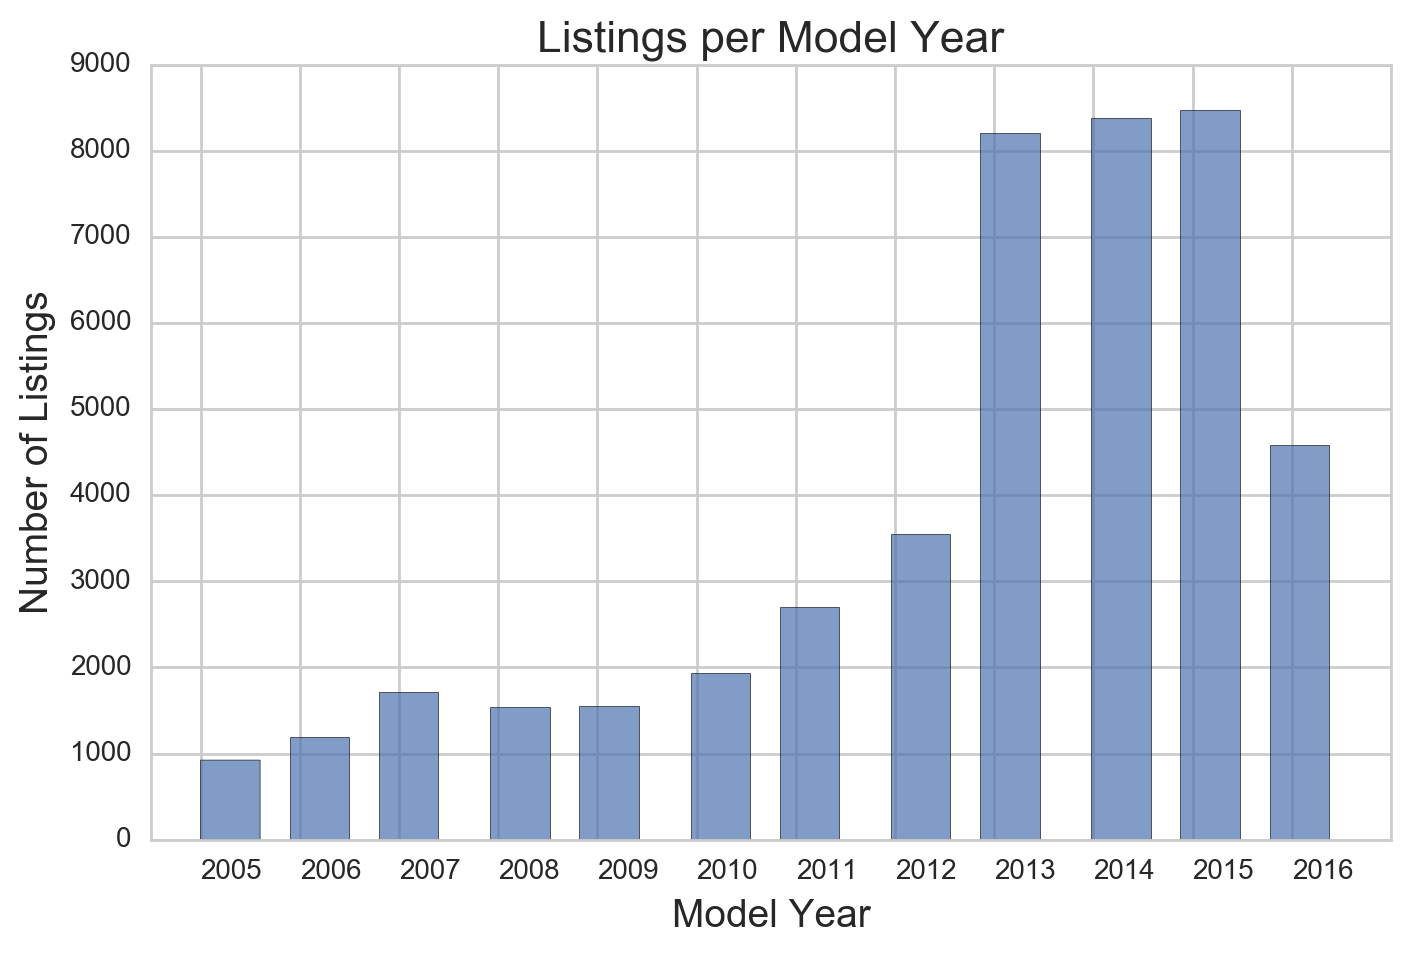

In [16]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(cc_data.modelYear,kde=False, hist_kws={"alpha":0.7,'width':0.6})
plt.title('Listings per Model Year',fontsize=16)
plt.xticks(sorted(cc_data.modelYear.unique()),horizontalalignment='left')
plt.ylabel('Number of Listings',fontsize=14)
plt.xlabel('Model Year', fontsize=14)
plt.xlim(2004.5,2017)
plt.show()

Miles distribution over all the listings.

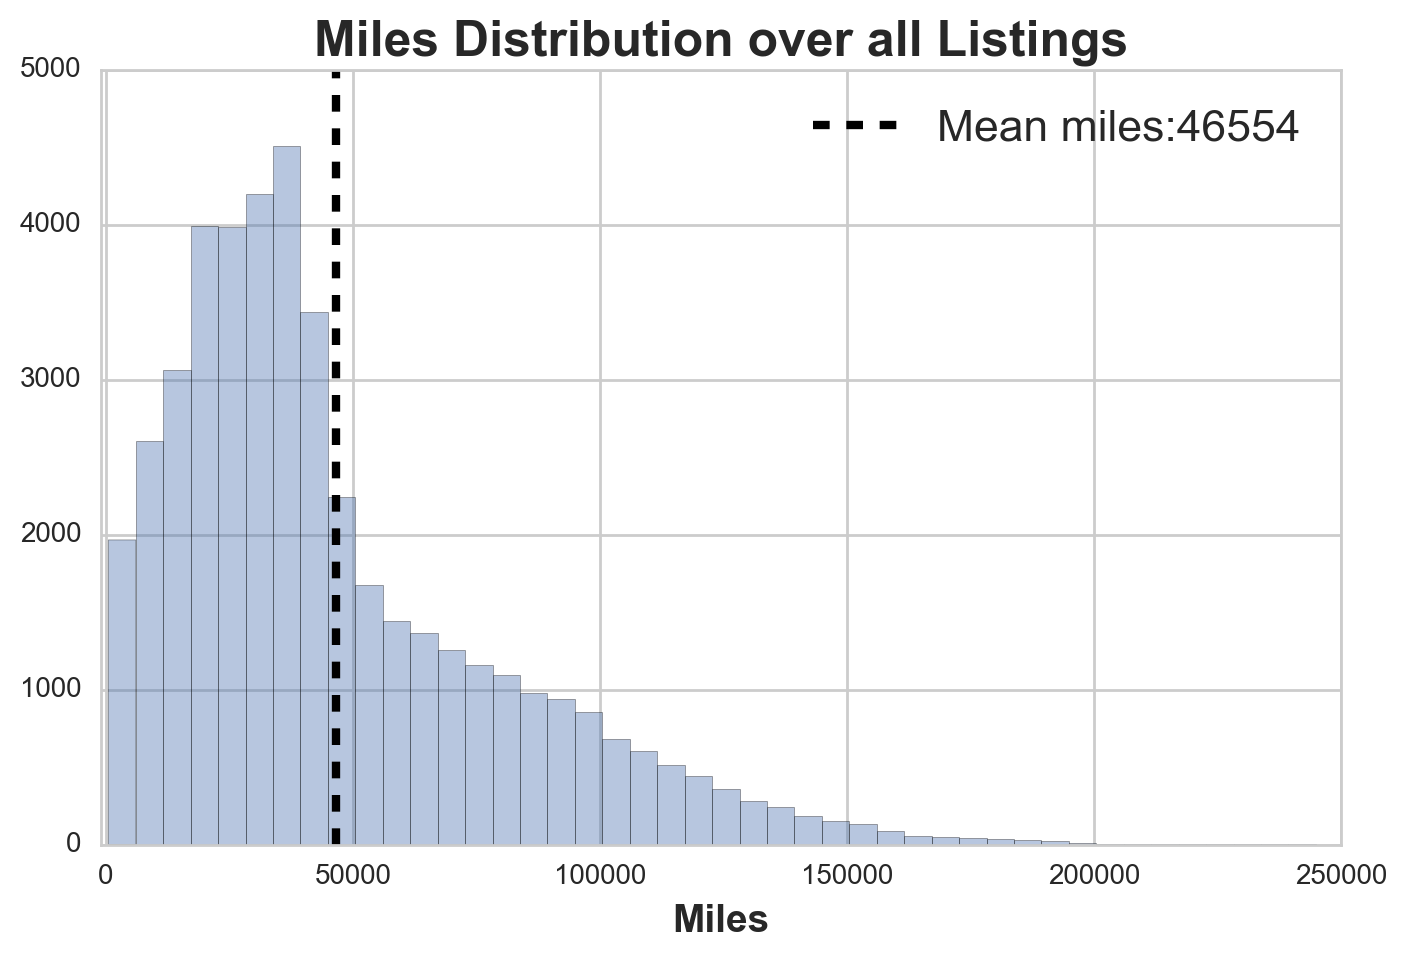

In [17]:
# look at miles overall distribution
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(cc_data.miles,kde=False)
plt.xlabel('Miles',fontsize=14,fontweight="bold")
plt.axvline(cc_data.miles.mean(),lw=3,ls='dashed',
            color='black',label='Mean miles:'+'{0:.0f}'.format(np.mean(cc_data.miles)))
plt.title('Miles Distribution over all Listings',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.xlim(-1000,250000)
plt.show()

Distribution of miles per year. Showing boxplot to get a better feel for the ranges and possible outliers.

Quite a few vehicles have very low miles.

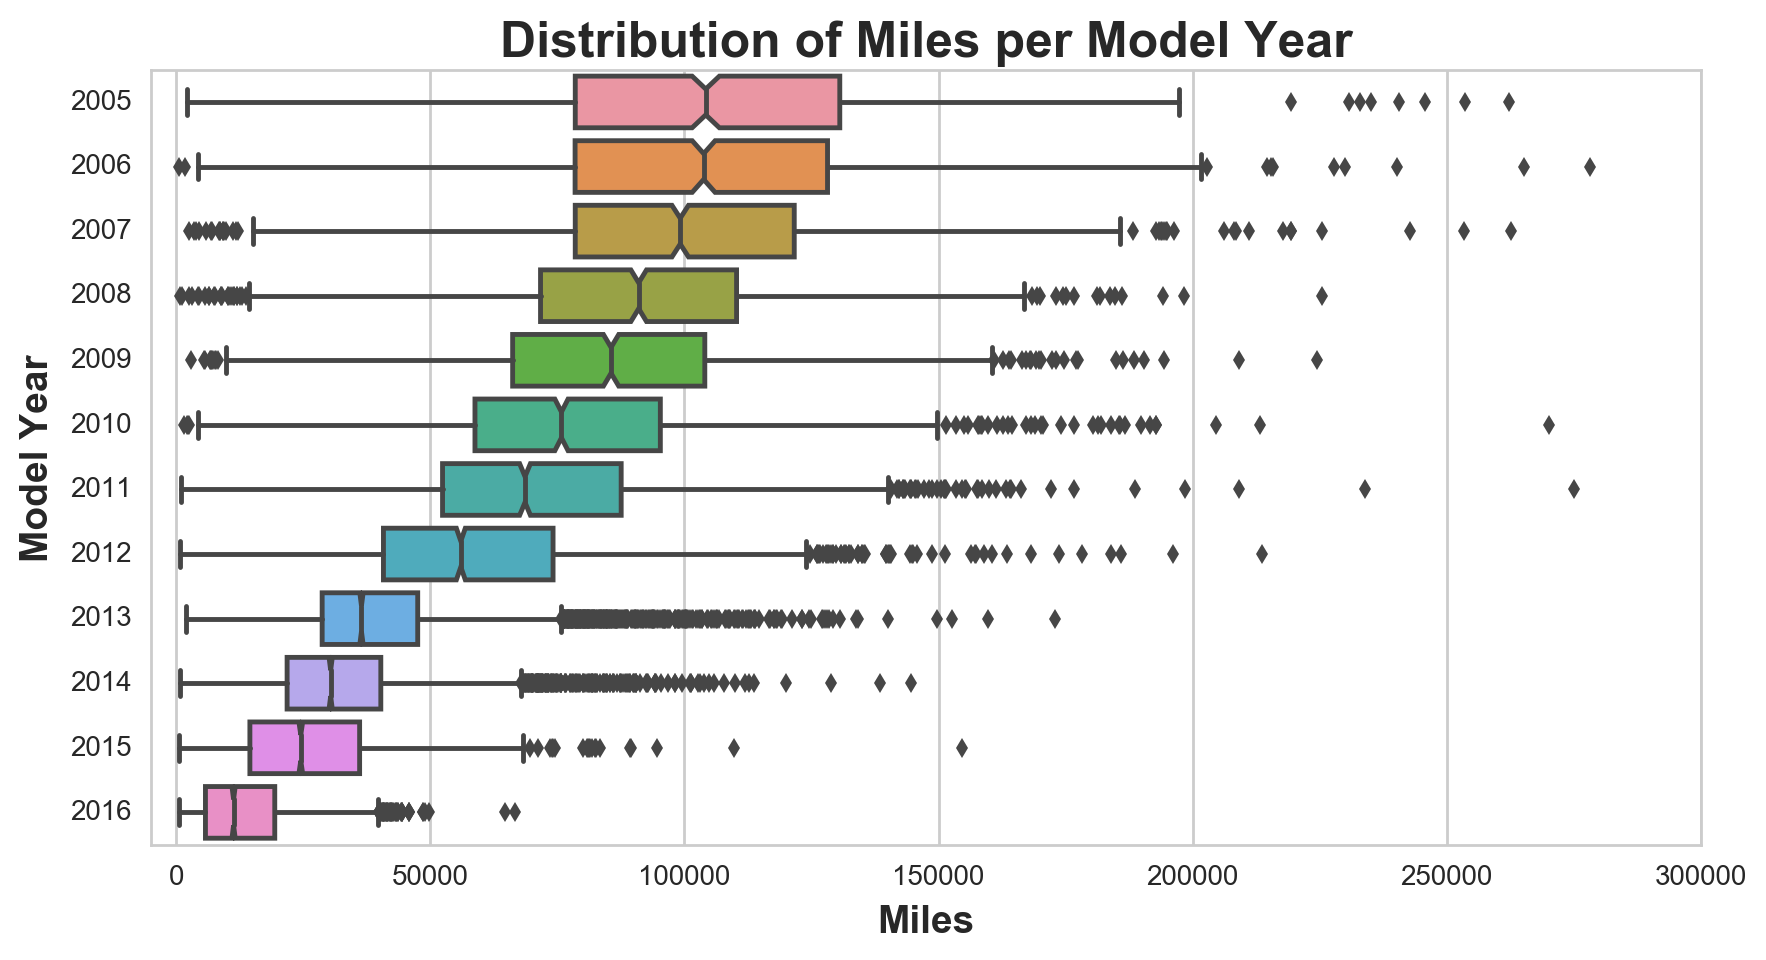

In [18]:
# look at miles by year boxplot
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
sns.boxplot(x='miles',y='modelYear',data=cc_data,notch=True,orient='h')
plt.xlabel('Miles',fontsize=14,fontweight="bold")
ax.set_yticklabels(sorted(cc_data.modelYear.unique()))
plt.ylabel('Model Year',fontsize=14,fontweight="bold")
plt.title('Distribution of Miles per Model Year',fontsize=18,fontweight="bold")
plt.xlim(-5000,300000)
plt.show()

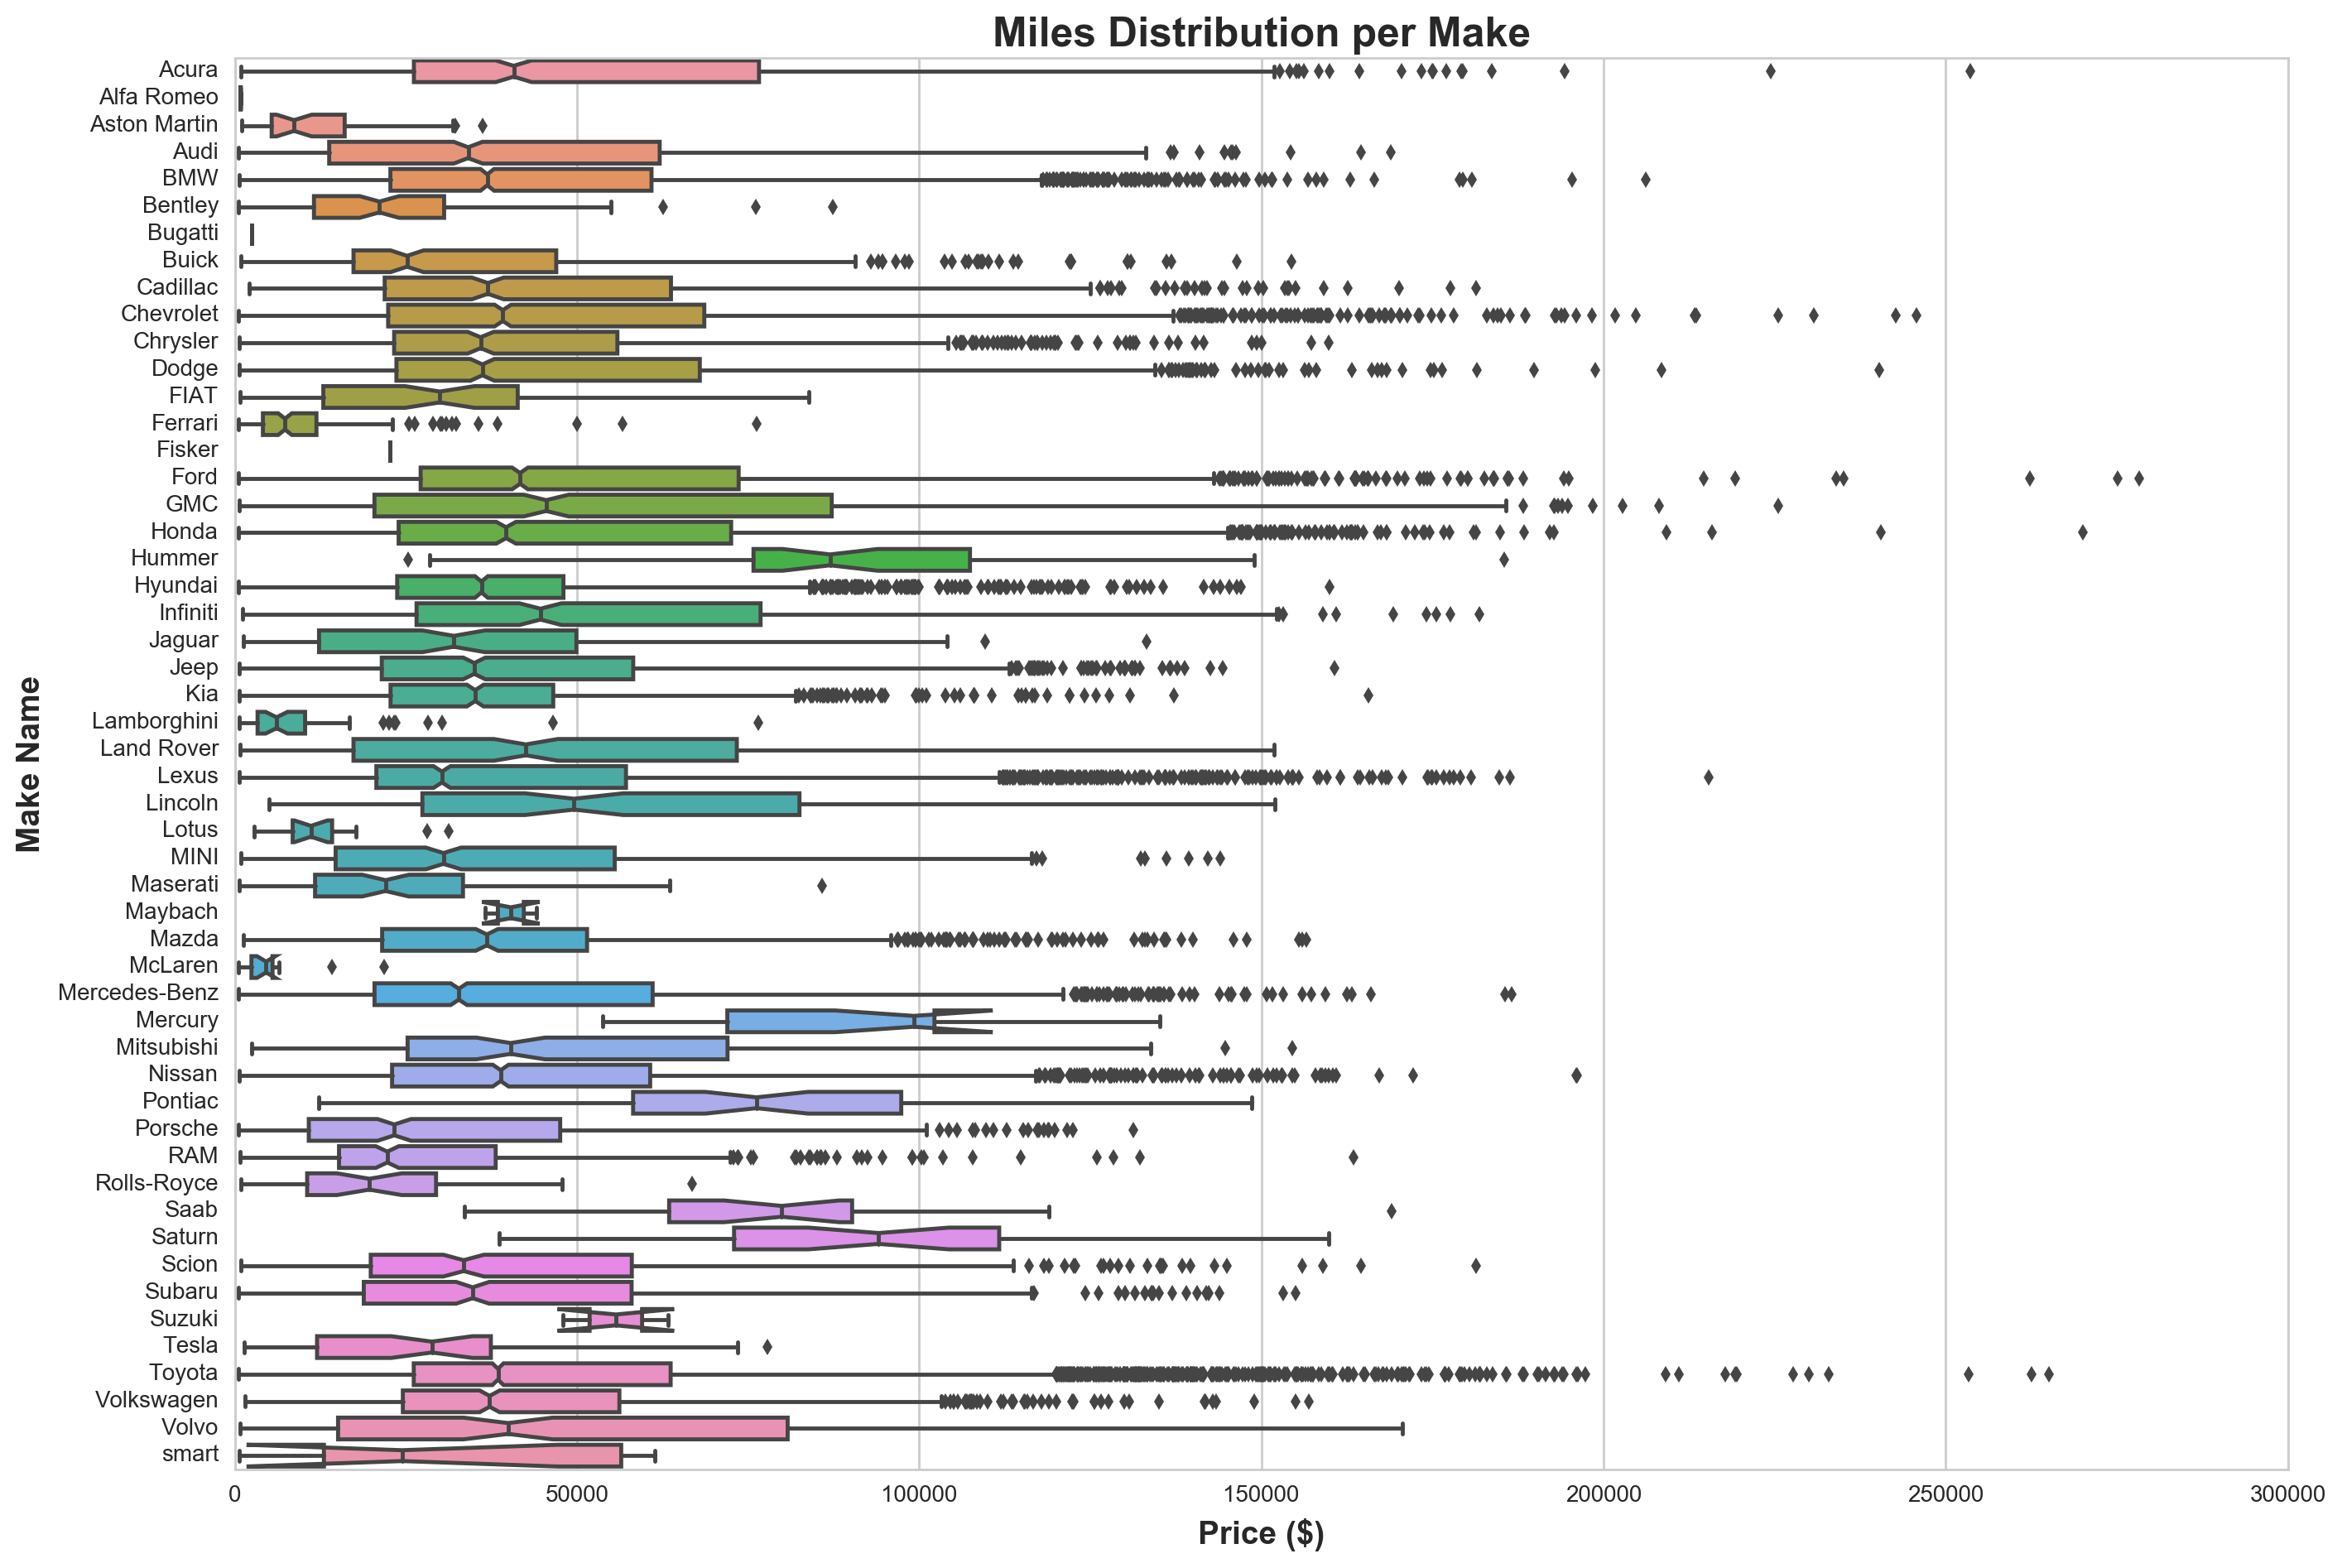

In [19]:
# look at miles by make boxplot
# limit upper prices so it's more informative

fig = plt.figure(figsize=(16,11))
ax = fig.gca()
sns.boxplot(x='miles',y='makeName',data=cc_data,
            order=sorted(cc_data.makeName.unique()),notch=True,orient='h')
plt.xlabel('Price ($)',fontsize=14,fontweight="bold")
plt.ylabel('Make Name',fontsize=14,fontweight="bold")
plt.title('Miles Distribution per Make',fontsize=18,fontweight="bold")
plt.show()

Overall price distribution. Limiting the data used for this plot to \$150k on the high end, as it tails off quite a bit to reach the highest price of $2M.

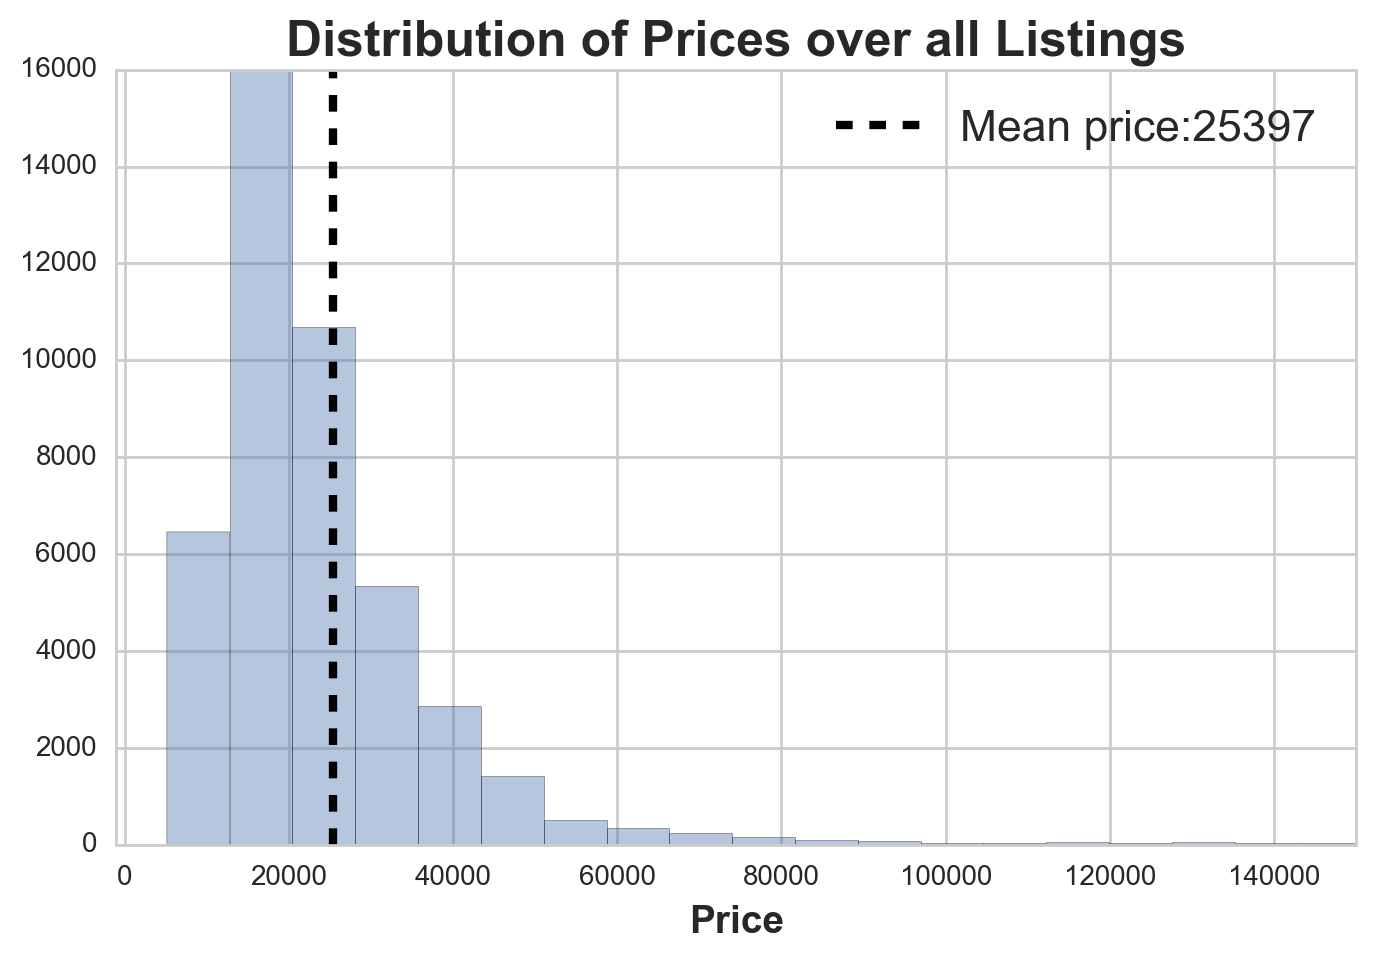

In [20]:
# look at price distribution
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(cc_data.price,kde=False,bins=300)
plt.xlabel('Price',fontsize=14,fontweight="bold")
plt.axvline(cc_data.price.mean(),lw=3,ls='dashed',
            color='black',label='Mean price:'+'{0:.0f}'.format(np.mean(cc_data.price)))
plt.title('Distribution of Prices over all Listings',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.xlim(-1000,150000)
plt.show()

Price per year boxplot with the same price restriction as above.

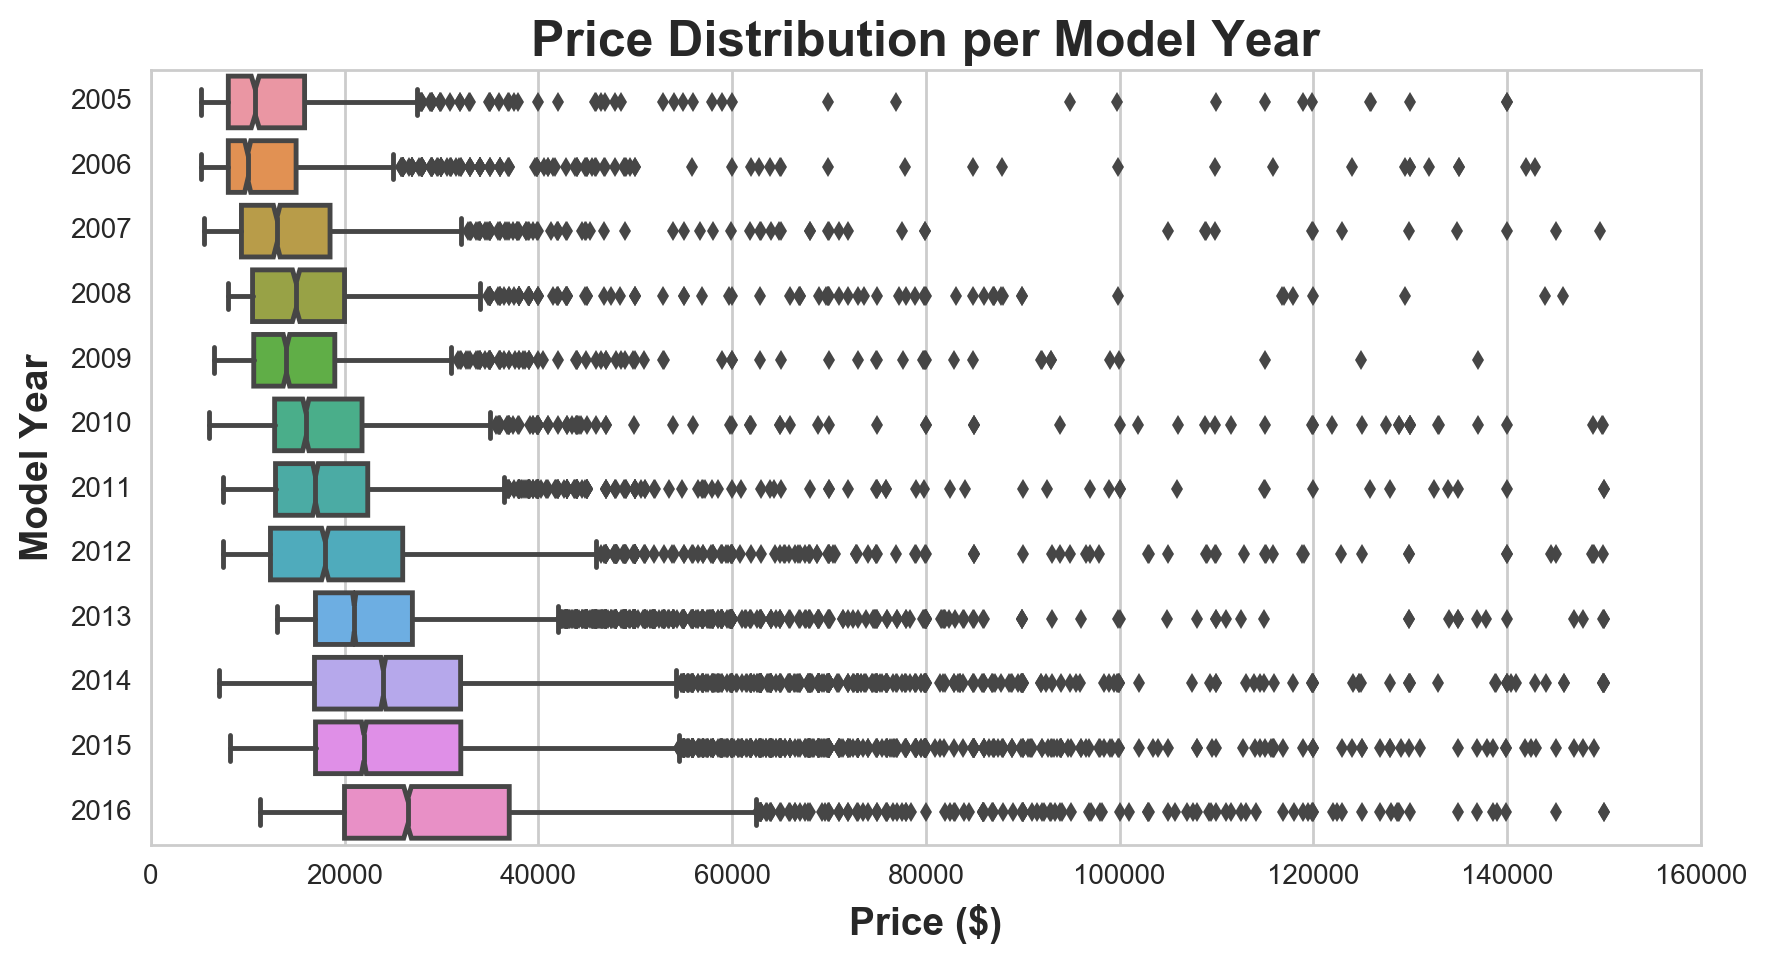

In [21]:
# look at price by year boxplot
# limit upper prices so it's more informative
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
sns.boxplot(x='price',y='modelYear',data=cc_data[cc_data.price < 150000],
            order=sorted(cc_data.modelYear.unique()),notch=True,orient='h')
plt.xlabel('Price ($)',fontsize=14,fontweight="bold")
#ax.set_yticklabels(sorted(cc_data.modelYear.unique()))
plt.ylabel('Model Year',fontsize=14,fontweight="bold")
plt.title('Price Distribution per Model Year',fontsize=18,fontweight="bold")
plt.show()

Now for the fun stuff! Look at prices by make. These next couple of plots are large!

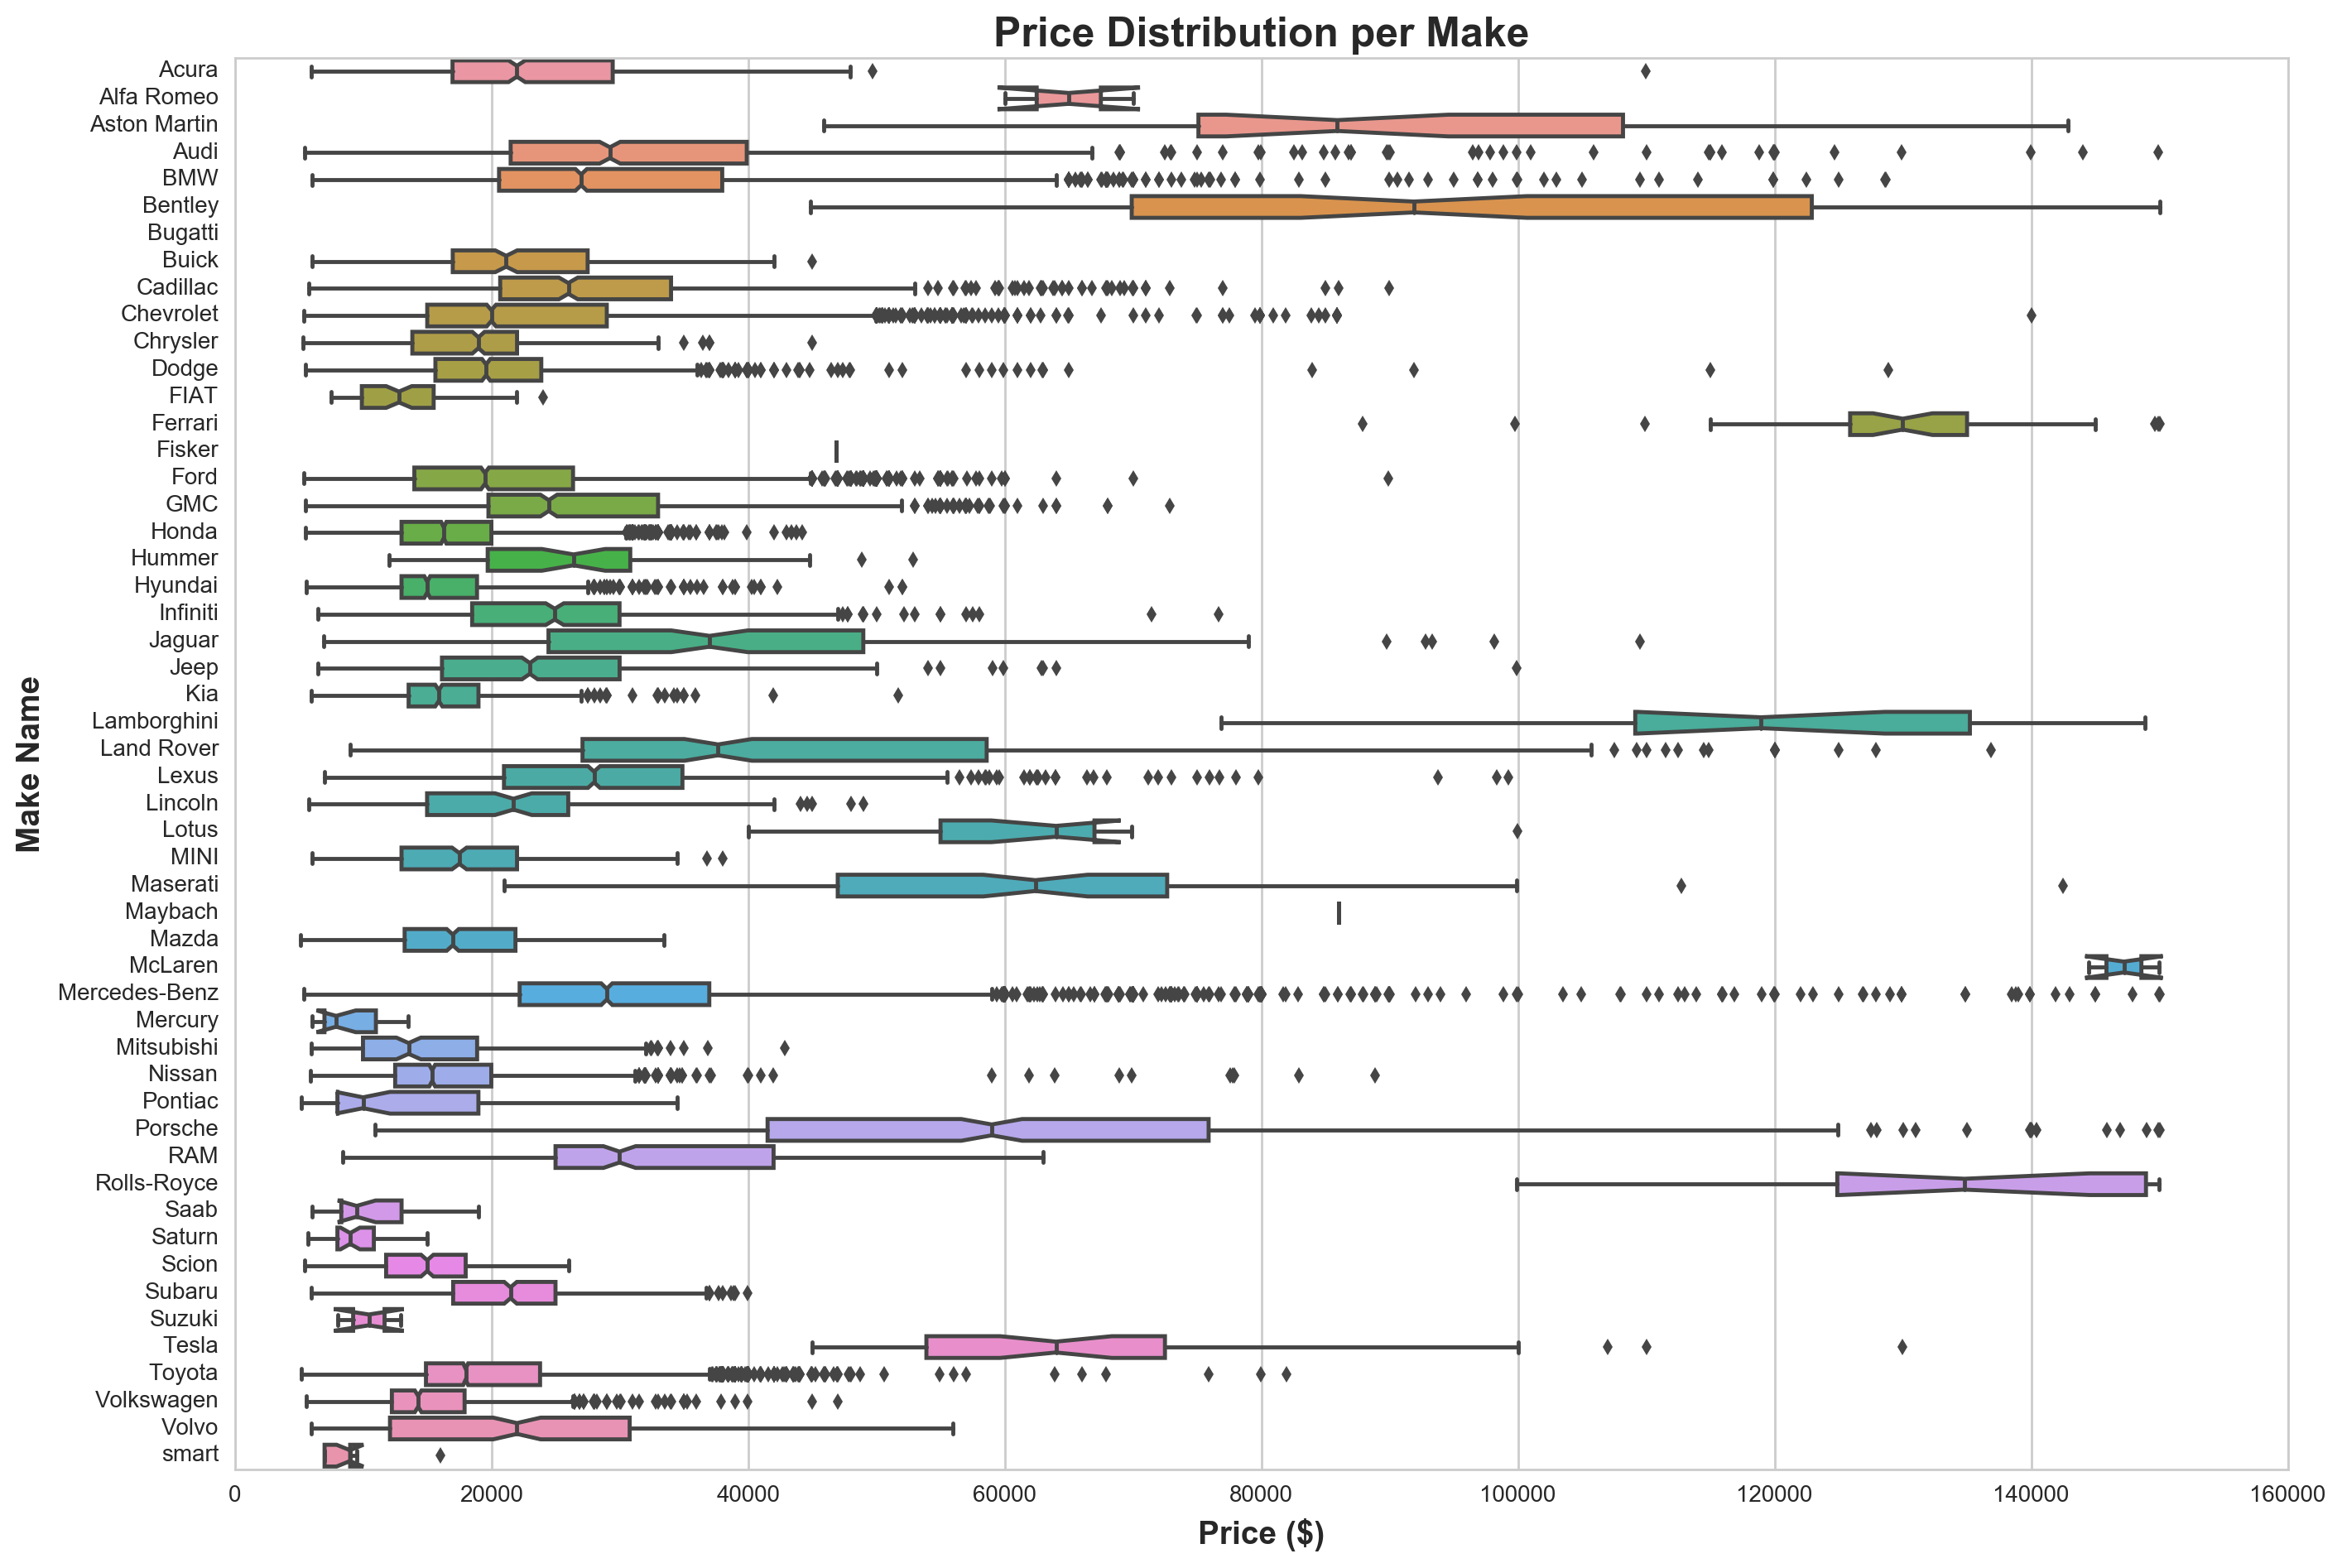

In [22]:
# look at price by make boxplot
# limit upper prices so it's more informative
fig = plt.figure(figsize=(16,11))
ax = fig.gca()
sns.boxplot(x='price',y='makeName',data=cc_data[cc_data.price < 150000],
            order=sorted(cc_data.makeName.unique()),notch=True,orient='h')
plt.xlabel('Price ($)',fontsize=14,fontweight="bold")
plt.ylabel('Make Name',fontsize=14,fontweight="bold")
plt.title('Price Distribution per Make',fontsize=18,fontweight="bold")
plt.show()

The plot above shows that even with a specific make, there can be very large price variations. Not too surprising when you consider that many makes have a 'halo vehicle' that is sold at a high price and in very small numbers. I'm not going to plot the price breakdown for each model within a make, as that is simply too large a plot. 

However, I will plot the price distribution by make per year, as it's important to show just how much the price changes over time. And while the prices tend to decrease with age, it's not always the case. This is a large plot...

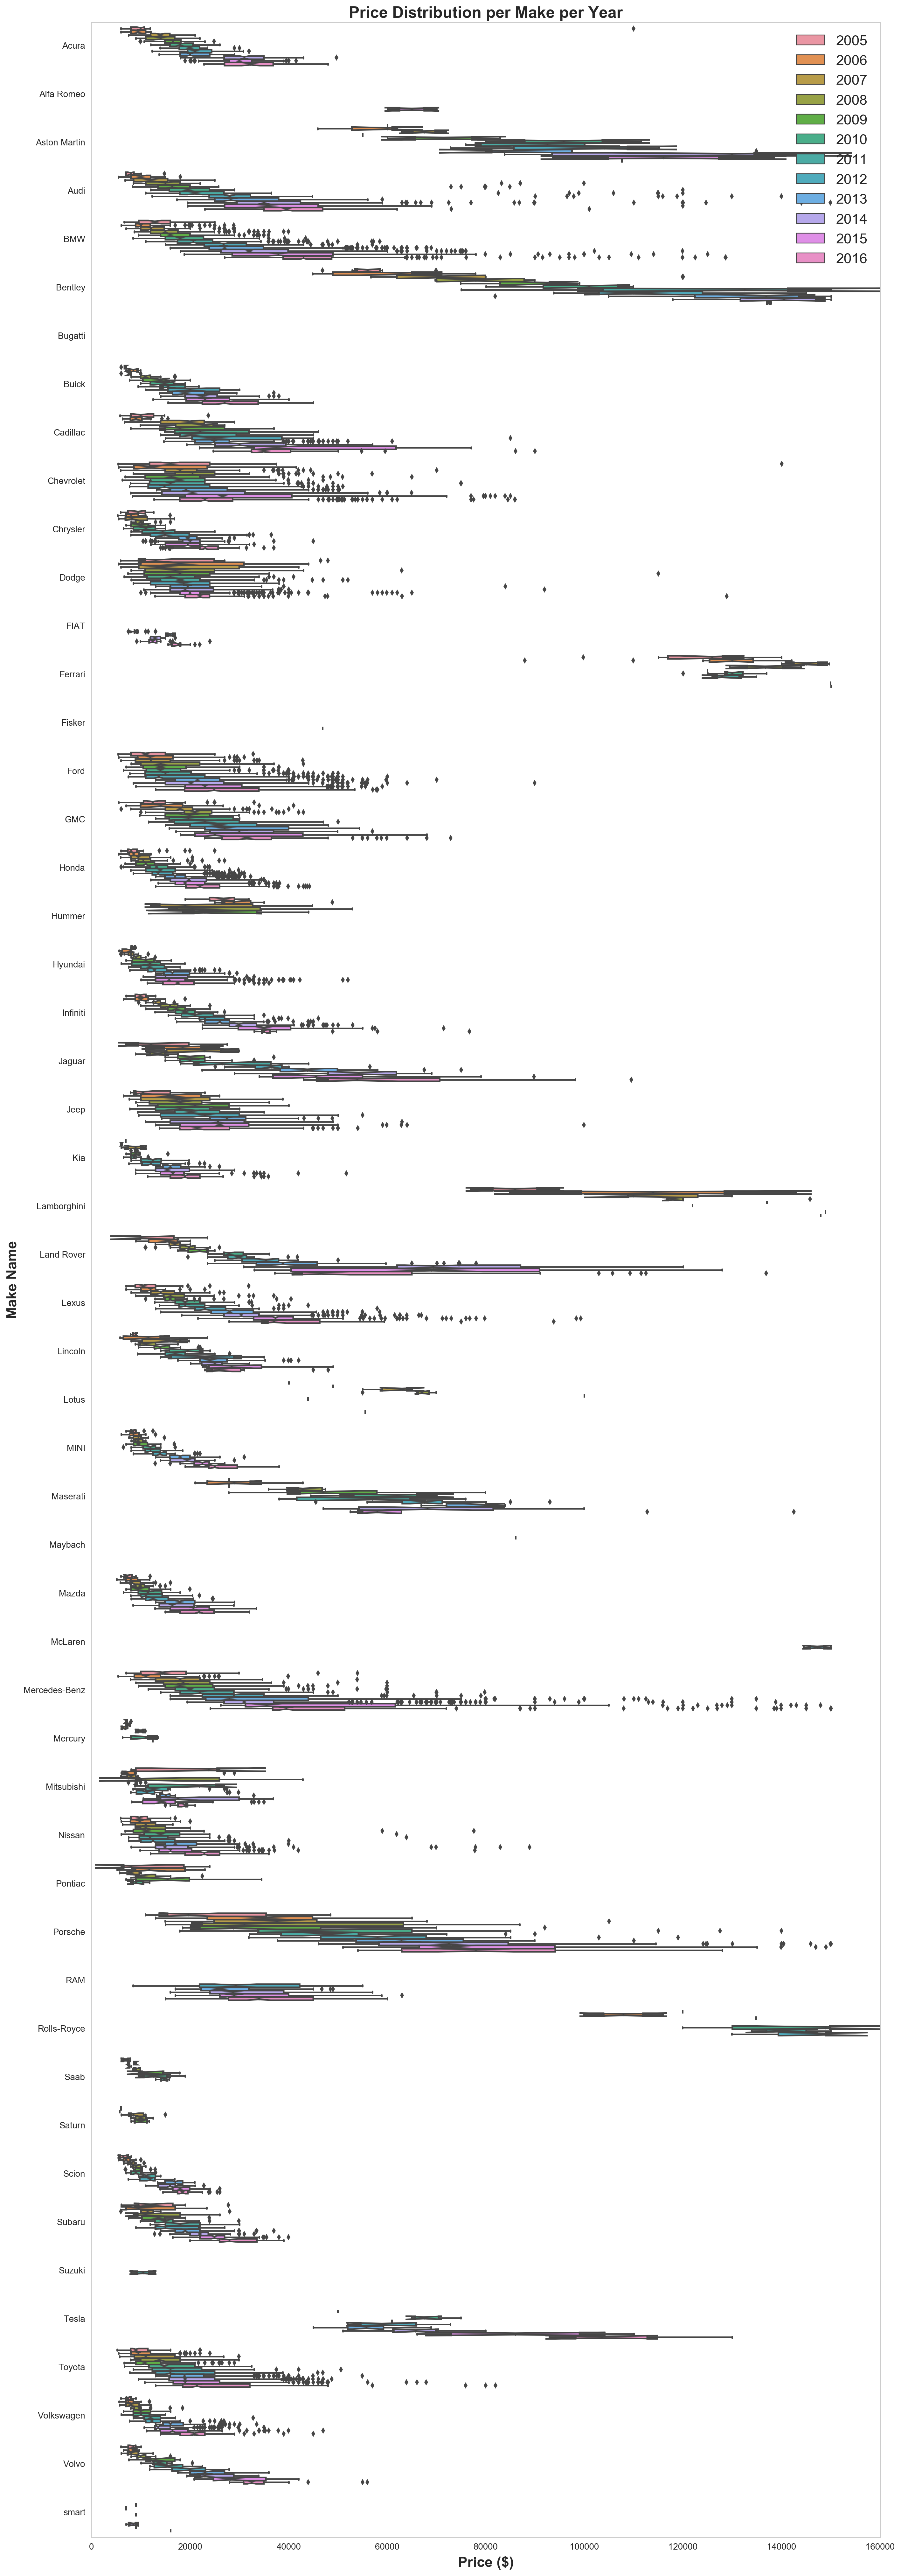

In [155]:
# look at price by make by year boxplot
# limit upper prices so it's more informative
# this has to be very large to get any details out

ordered_makes = sorted(cc_data.makeName.unique())

fig = plt.figure(figsize=(16,51))
ax = fig.gca()
sns.boxplot(x='price',y='makeName',data=cc_data[cc_data.price < 150000],
            order=ordered_makes,hue=(cc_data.modelYear),notch=True,orient='h')
plt.xlabel('Price ($)',fontsize=16,fontweight="bold")
plt.ylabel('Make Name',fontsize=16,fontweight="bold")
plt.title('Price Distribution per Make per Year',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.show()

This is a similar plot as above, just limiting it to a few makes so the trends are easier to observe.

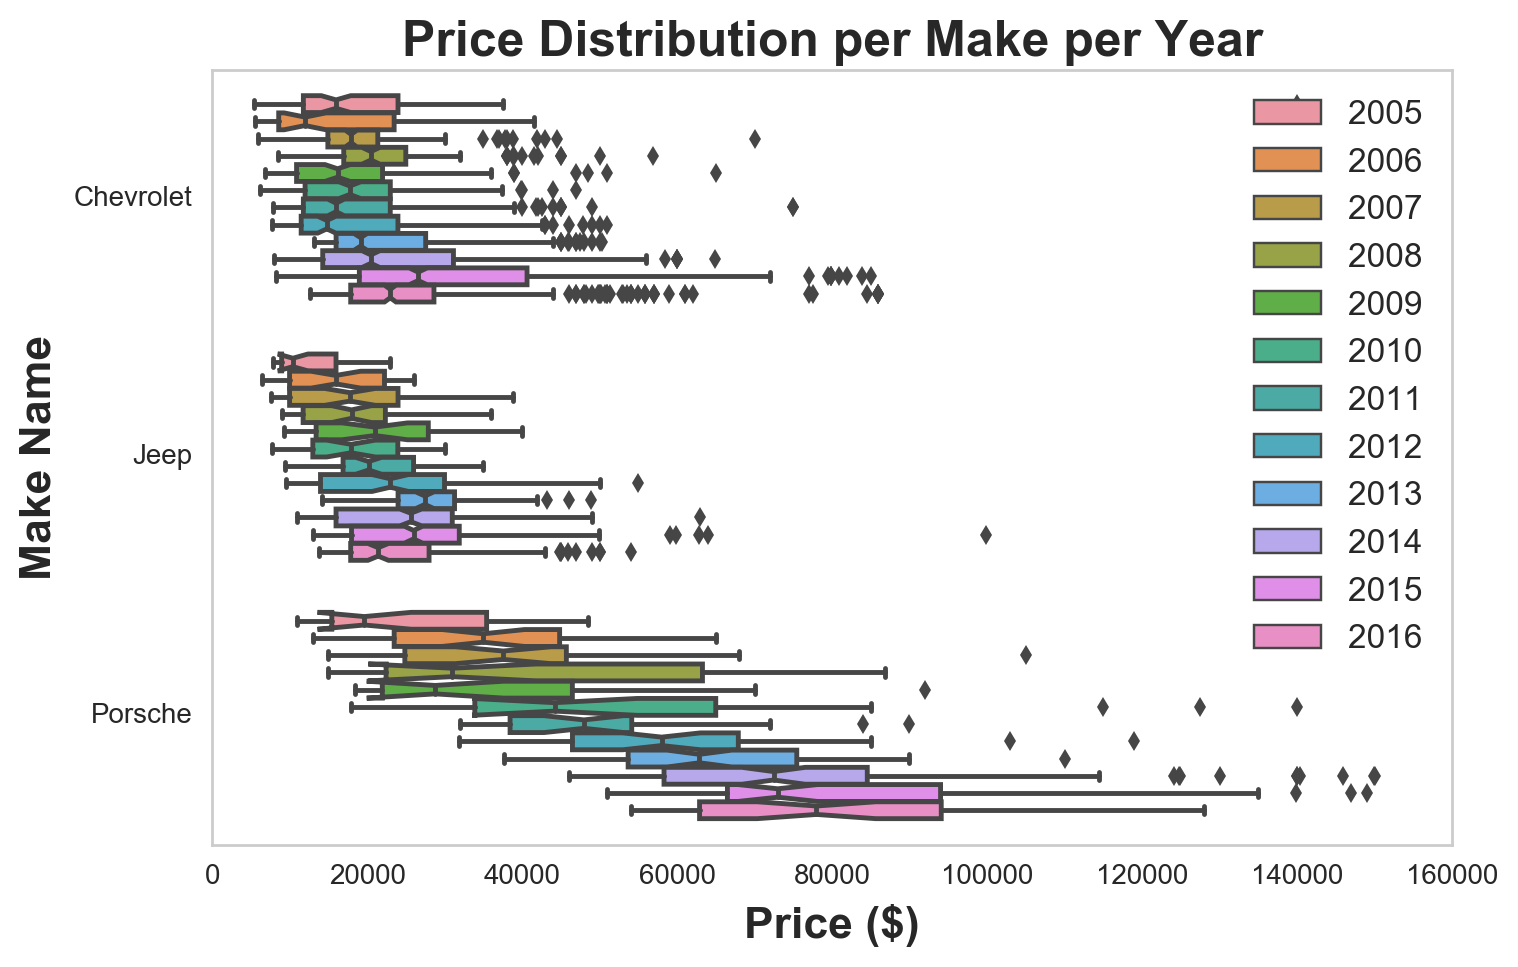

In [201]:
# look at price by make by year boxplot
# limit upper prices so it's more informative
# 

#ordered_makes = sorted(cc_data.makeName.unique())
temp = cc_data[(cc_data.price < 150000) & ((cc_data.makeName == 'Jeep') | (cc_data.makeName == 'Porsche') | (cc_data.makeName == 'Chevrolet'))]

fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.boxplot(x='price',y='makeName',data=temp,order=['Chevrolet','Jeep','Porsche'],
            hue=(temp.modelYear),notch=True,orient='h')
plt.xlabel('Price ($)',fontsize=16,fontweight="bold")
plt.ylabel('Make Name',fontsize=16,fontweight="bold")
plt.title('Price Distribution per Make per Year',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=12)
plt.show()

# 6. Model Selection

## 6.1 Bayesian Linear Regression

In order to determine if a vehicle is a good value or not, I will use linear regression to predict the price distribution for each combination of year, make, and mode, and then compare it to the actual price. If they are similar, then it is 'reasonable,' otherwise the shopper may want to investigate why the vehicle is priced too high or low vs the prediction. 

This problem is ideally suited Bayesian methods, specifically to using a hierarchical model. As shown in the 'price by make and year' distribution plot above, a traditional linear regression would likely have trouble producing reasonable predictions, even if the regression was done by make. Limiting it further by year, model and trim levels could negatively impact the performance due to potentially small sample sizes.

To get around this issue, I use a Bayes hierarchical model that predicts a price given the miles of the vehicle while taking into account prior knowledge about prices based on year, model and trim. This gives a distribution of estimated prices (posterior probabilities), against which the original asking price can be compared.

## 6.2 Recommendation Engine

For the recommendation engine, I will build a content-based model that is trained on the descriptive features available for each vehicle. Using that, it will be possible to predict which vehicles are most similar to each other, and that information can be returned to the user.

To do this, I will create a sentence that describes each vehicle, composed of the following parts:
- year
- make
- model
- trim
- transmission
- drivetype
- engine
- exterior color
- interior color

From there, I will tokenize the sentence using the tf-idf vectorizer. This will return the proportion that each token appears in the overall collection of sentences, with the value weighted by its frequency. N-gram values of 1 through 4 are used (one, two, three, and four-word phrases), as that ensures that the vehicles with the same 'year make model trim' (**ymmt**) will be ranked as highly similar to each other, with further separation provided by the descriptors. Finally, the similarity ranking for each listing against all the other listings will be calculated using the cosine similarity function. Then the rankings can be sorted by similarity and used to do things such as finding a related vehicle with a lower price.

# 7. Modeling

Make a column 'ymmt' containing year make model trim.

In [24]:
def ymmt_cc(df):

    # making all of these string, as some are numeric
    year = str(df.modelYear)
    make = str(df.makeName)
    model = str(df.modelName)
    # deal with case of no trim level
    if df.trimName != None:
        trim = str(df.trimName)
    else:
        trim = ''
    ymmt = ' '.join([year,make,model,trim])
    return ymmt
    
cc_data['ymmt'] = cc_data.apply(ymmt_cc,axis=1)
cc_data['ymmt'].head()

0                     2006 Ford F250 
1                   2006 Lotus Elise 
2    2006 Rolls-Royce Phantom VI Base
3            2006 Maserati GranSport 
4                   2006 Ford F350 XL
Name: ymmt, dtype: object

Add a column for engine displacement. This will make it easier to use engine-based info, as they will be all be formatted the same. Will set to *0* for electric vehicles.

In [25]:
# first do the non-electric cars
# can extract the displacement by looking for two digits separated by '.'
# that will diffrentiate from other descriptions such as '32V' 
cc_data['displacement'] = cc_data.engine.str.extract('(\d\.\d)',expand=False).copy()
# set the type to float
cc_data.displacement.astype('float')

# Chevy Volt should be at 1.5
# this is called 'electric' in some listings, which is not quite correct
cc_data.displacement[cc_data.modelName == 'Volt'] = 1.5
cc_data.displacement[cc_data.modelName == 'Volt'].head()

# also need to set the displacement to 0 for electric vehicles
cc_data.displacement[(cc_data.fuelType == 'Electric') & (cc_data.modelName != 'Volt')] = 0.
print "Number of rows without engine displacement:", len(cc_data[['modelYear','makeName','modelName','engine']][cc_data.displacement.isnull() == True])

Number of rows without engine displacement: 1211


Create two additional columns for transmission:
- transAM: either 'automatic' or 'manual'
- transBin: 0 for automatic and 1 for manual

If there is no transmission info, will set to automatic as that's most common in US.

In [26]:
cc_data['transAM'] = cc_data.transmission.map(lambda x: 'manual' if ('man' in str(x).lower()) else 'automatic')
cc_data['transBin'] = cc_data.transmission.map(lambda x: 1 if ('man' in str(x).lower()) else 0)

Simplify the drivetrain options to:
- FWD: front wheel drive
- RWD: rear wheel drive
- AWD: all wheel drive

And store in a new column: drivetype

In [27]:
def set_drivetype(row):
    # initialize the output variable with '' in case there is not driveline info
    dt = ''
    # make sure there is some information to parse
    if row != None:
        dl = row.lower()
        # look for rear wheel drive
        if ('rear' in dl) or (dl == 'rwd'):
            dt = 'RWD'
        # look for front wheel drive
        elif (dl == 'fwd') or ('front' in dl):
            dt = 'FWD'
        # otherwise assume all wheel drive
        else:
            dt = 'AWD' 
        return dt
    
cc_data['drivetype'] = cc_data.drivetrain.map(set_drivetype)
print cc_data.drivetype.value_counts()
print cc_data.drivetype.unique()

FWD    20631
RWD    13762
AWD     9745
Name: drivetype, dtype: int64
['AWD' 'RWD' 'FWD' None]


Functions for loading and saving gzipped pickle files

In [28]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)

Reset the index and save results for use in the modeling steps

In [29]:
cc_data.reset_index(inplace=True,drop=True)

cc_file = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/cc_data_clean.pgz'

save_zipped_pickle(cc_data,cc_file)

## 7.1  Bayesian Linear Regression

#### Due to the size of the dataset and amount of time it takes to run the Bayes processing, I will limit the data here to a single make for use with model code shown below.

In [30]:
# additional imports
import pymc3 as pm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from PIL import Image

Prepare the Bayesian Linear Regression and output.

- Run for one make, model, and year at a time and save the output for each one:
  - make_bayes.p -> which is bayes_by_ymm[makeNake] and contains the traces 
  - make_df.p -> this has the 'ymmt' info and the posterior price probability distribution, but only for ymmt that are found in the parent cc_data 

** This is too computationally intensive to run on my local machine, so it's been run on an AWS instance (g2.2xlarge). Even there, it is limited more by available memory than processing speed.**

The code used on AWS is shown below. For this notebook, I've limited it to one make, one model, and two years, and will then load in the other results below.

In [31]:
make_names = cc_data.makeName.unique()

# number of iterations
niter = 100000

# set make to just Porsche for this notebook
make_names = ['Porsche']

for make in make_names:
    # dictionaries to store the the traces
    bayes_by_ymm = {}
    bayes_by_model = {}
    # final dataframe
    bayes_make_model_year = pd.DataFrame()

    # keep track of time
    d1 = datetime.now()

    # subset data for just the single make
    cc_data_make = cc_data[cc_data.makeName == make]

    # define the model info for each make
    model_coder = LabelEncoder()
    cc_data_make['model_code'] = model_coder.fit_transform(cc_data_make.modelName)
    model_codes = cc_data_make.model_code.unique()
    model_codes_idx = cc_data_make.model_code.values
    num_model_codes = len(model_codes)
    model_names = cc_data_make.modelName.unique()

    #for model in model_names:
    for mdl,mdl_i in enumerate(model_codes[0:1]):
        model = str(model_coder.inverse_transform(mdl))
        bayes_by_year = {}

        #further subset the data
        cc_data_model = cc_data_make[cc_data_make.modelName == model]

        # define the year info for each make
        year_le = LabelEncoder()
        cc_data_model['year_code'] = year_le.fit_transform(cc_data_model.modelYear)
        years = cc_data_model.year_code.unique()
        year_codes_idx = cc_data_model.year_code.values
        num_years = len(cc_data_model.year_code.unique())
        year_codes = cc_data_model.year_code.unique()

        # run for each year of each model
        for yr,yr_1 in enumerate(year_codes[0:2]):

            year = str(year_le.inverse_transform(yr))

            # subset the data again
            cc_data_year = cc_data_model[cc_data_model.modelYear == int(year)]

            # define trims for each make
            trim_coder = LabelEncoder()
            cc_data_year['trim_code'] = trim_coder.fit_transform(cc_data_year.trimName)
            trim_codes = cc_data_year.trim_code.unique()
            trim_codes_idx = cc_data_year.trim_code.values
            num_trims = len(trim_codes)

            print "Now processing %s %s %s with %s trim levels" % (year,make,model,num_trims)

            with pm.Model() as price_ymm:

                # define the priors and distributions for:

                # intercept priors and distribution: trim

                # set mu for the intercept to the mean price
                # need to do this for cases where there aren't many samples, otherwise
                # the distribution stays centered on zero
                intercept_mu = cc_data_year.price.mean()

                intercept_trim_mean = pm.Normal('intercept_trim_mean', mu=intercept_mu, sd=10000.)
                intercept_trim_sd = pm.Normal('intercept_trim_sd',mu=intercept_mu, sd=10000.)
                intercept_trim_overall = pm.Normal('intercept_trim_overall',
                                            mu=intercept_trim_mean, sd=intercept_trim_sd, shape=num_trims)

                # miles priors: trim
                miles_trim_mean = pm.Normal('miles_trim_mean', mu=0, sd=10000.)
                miles_trim_sd = pm.Gamma('miles_trim_sd', mu=0.0001, sd=10000.)
                # miles distribuitions
                miles_trim_overall = pm.Normal('miles_trim_overall',mu=miles_trim_mean,
                                          sd=miles_trim_sd, shape=num_trims)

                # regression formula
                price_est = (intercept_trim_overall[trim_codes_idx] +
                             miles_trim_overall[trim_codes_idx]*cc_data_year.miles.values)

                # model error
                model_error = pm.Uniform('model_error', lower=0, upper=100000)

                # calculate likelihood
                price_like = pm.Normal('price_like', mu=price_est, sd=model_error, observed=cc_data_year.price.values)

                step = pm.Metropolis()

                # run
                trace = pm.sample(niter,step=step)

                print '\n'

                # don't keep all the traces
                bayes_by_year[year] = trace[niter/2:]

            # outside the Bayes model now
            # create and populate the dataframe
            # define lists that will be used when creating the new dataframe
            yr_names = []
            yr_codes = []
            mk_names = []
            mdl_names = []
            mdl_codes = []
            trm_names = []
            trm_codes = []
            ymmts = []
            prob_dists = []

            # go through each trim level
            for trm,trm_i in enumerate(trim_codes):

                # now get the year, model, trim values back from using the inverse encoder
                yr_e = year_le.inverse_transform(yr)
                mdl_e = str(model_coder.inverse_transform(mdl))
                # check if trim has a value or not
                if trim_coder.inverse_transform(trm) != None:
                    trm_e = str(trim_coder.inverse_transform(trm))
                else:
                    trm_e = ''

                # create ymmt value
                ymmt = ' '.join([str(yr_e),make,mdl_e,trm_e])

                # if the ymmt isn't in the parent set, then it doesn't
                # need to be in the final df
                if len(cc_data[cc_data.ymmt == ymmt]) > 0:

                    # fill lists that will be used when creating the new dataframe
                    ymmts.append(ymmt)
                    yr_names.append(yr_e)
                    yr_codes.append(yr)
                    mk_names.append(make)
                    mdl_names.append(mdl_e)
                    mdl_codes.append(mdl)
                    trm_names.append(trm_e)
                    trm_codes.append(trm)

                    # get the price probability dist for each ymmt from the bayes files
                    prob =      (bayes_by_year[year]['intercept_trim_overall'][:,trm] +
                                 bayes_by_year[year]['miles_trim_overall'][:,trm])

                    prob_dists.append(prob)

                else:
                    pass

            # put it all in a datafram
            year_df = pd.DataFrame({
                    'ymmt':ymmts,
                    'makeName':mk_names,
                    'modelYear':yr_names,
                    'year_code':yr_codes,
                    'modelName':mdl_names,
                    'model_code':mdl_codes,
                    'trimName':trm_names,
                    'trim_code':trm_codes,
                    'prob_dists':prob_dists
                })

            # update the dataframe
            bayes_make_model_year = pd.concat((bayes_make_model_year,year_df))

            # save traces with model
            bayes_by_model[model] = bayes_by_year

        # save traces by make
        bayes_by_ymm[make] = bayes_by_model
        #print bayes_by_ymm[make].keys()

    # reset the df index before saving
    bayes_make_model_year.reset_index(inplace=True,drop=True)
    # directory for saving the files
    #file_dir = '/home/ubuntu/bayes/'
    file_dir = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/bayes/'

    # save the dataframe
    df_file = file_dir+str(make)+'_df.pgz'
    #save_zipped_pickle(bayes_make_model_year,df_file)

    # file name for the traces
    trace_file = file_dir +str(make)+'_bayes.pgz'
    # save the traces
    # pickle the traces to save the output
    #save_zipped_pickle(bayes_by_ymm,trace_file)

    d2 = datetime.now()
    time_diff = int((d2-d1).total_seconds() / 60)
    print '\nWrote:\n%s and \n%s\nTotal processing time for %s: %s minutes\n' % (trace_file,df_file,make,time_diff)


Now processing 2005 Porsche 911 with 5 trim levels
Applied log-transform to miles_trim_sd and added transformed miles_trim_sd_log_ to model.
Applied interval-transform to model_error and added transformed model_error_interval_ to model.
 [-----------------100%-----------------] 100000 of 100000 complete in 60.3 sec

Now processing 2006 Porsche 911 with 7 trim levels
Applied log-transform to miles_trim_sd and added transformed miles_trim_sd_log_ to model.
Applied interval-transform to model_error and added transformed model_error_interval_ to model.
 [-----------------100%-----------------] 100000 of 100000 complete in 51.6 sec


Wrote:
/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/bayes/Porsche_bayes.pgz and 
/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/bayes/Porsche_df.pgz
Total processing time for Porsche: 2 minutes



Read in the file from the AWS processing containing all the Porsche ymmt's.

In [135]:
with pm.Model():
    bayes_by_ymm = load_zipped_pickle('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/AWS_bayes/Porsche_bayes.pgz')


Content of dictionary that is storing the traces from the price_ymm pymc3 model:

In [136]:
print bayes_by_ymm.keys()
print bayes_by_ymm['Porsche'].keys()
print bayes_by_ymm['Porsche']['911'].keys()

[u'Porsche']
['911', 'Panamera Hybrid', 'Cayman', 'Cayenne', 'Cayenne Hybrid', 'Carrera GT', 'Boxster', 'Panamera', 'Cayenne E-Hybrid', 'Panamera e-Hybrid', 'Macan', '918 Spyder']
['2009', '2006', '2007', '2005', '2015', '2014', '2008', '2016', '2011', '2010', '2013', '2012']


The bayes_make_model_year dataframe contains the ymmt info for using with cc_data, in addition to the price probability distribution.

In [137]:
print bayes_make_model_year.shape
bayes_make_model_year[['ymmt','prob_dists']].head()

(12, 9)


ymmt  \
0                     2005 Porsche 911    
1              2005 Porsche 911 Carrera   
2    2005 Porsche 911 Carrera Cabriolet   
3            2005 Porsche 911 Carrera S   
4  2005 Porsche 911 Carrera S Cabriolet   

                                          prob_dists  
0  [34886.7782189, 34886.7782189, 34886.7782189, ...  
1  [34859.7078125, 34859.7078125, 34859.7078125, ...  
2  [38210.4264543, 38210.4264543, 38210.4264543, ...  
3  [39751.5066645, 39751.5066645, 39751.5066645, ...  
4  [43129.623794, 43129.623794, 43129.623794, 446...

The resulting trace plot for a single year, make, model is shown below.

The different colors of the traces reflect the different trim levels within the model. 

The plots in the left column are smoothed posterior distributions of the intercept and trim variables. These show the impact that each variable has on the calculation of the posterior prices (i.e., the predictions)

The right column are the values sampled for each variable during each iteration of the model fitting process. They have reached convergence when the lines begin to flatten out. While the job was run for 100000 iterations, only the second half of the tracaes are shown, as the initial iterations are the 'burn-in' phase where the model is still searching for the optimal parameters.

In [152]:
print 'Number of unique trim levels for 2006 Porsche 911:', len(cc_data_year.trimName.unique())

Number of unique trim levels for 2006 Porsche 911: 7


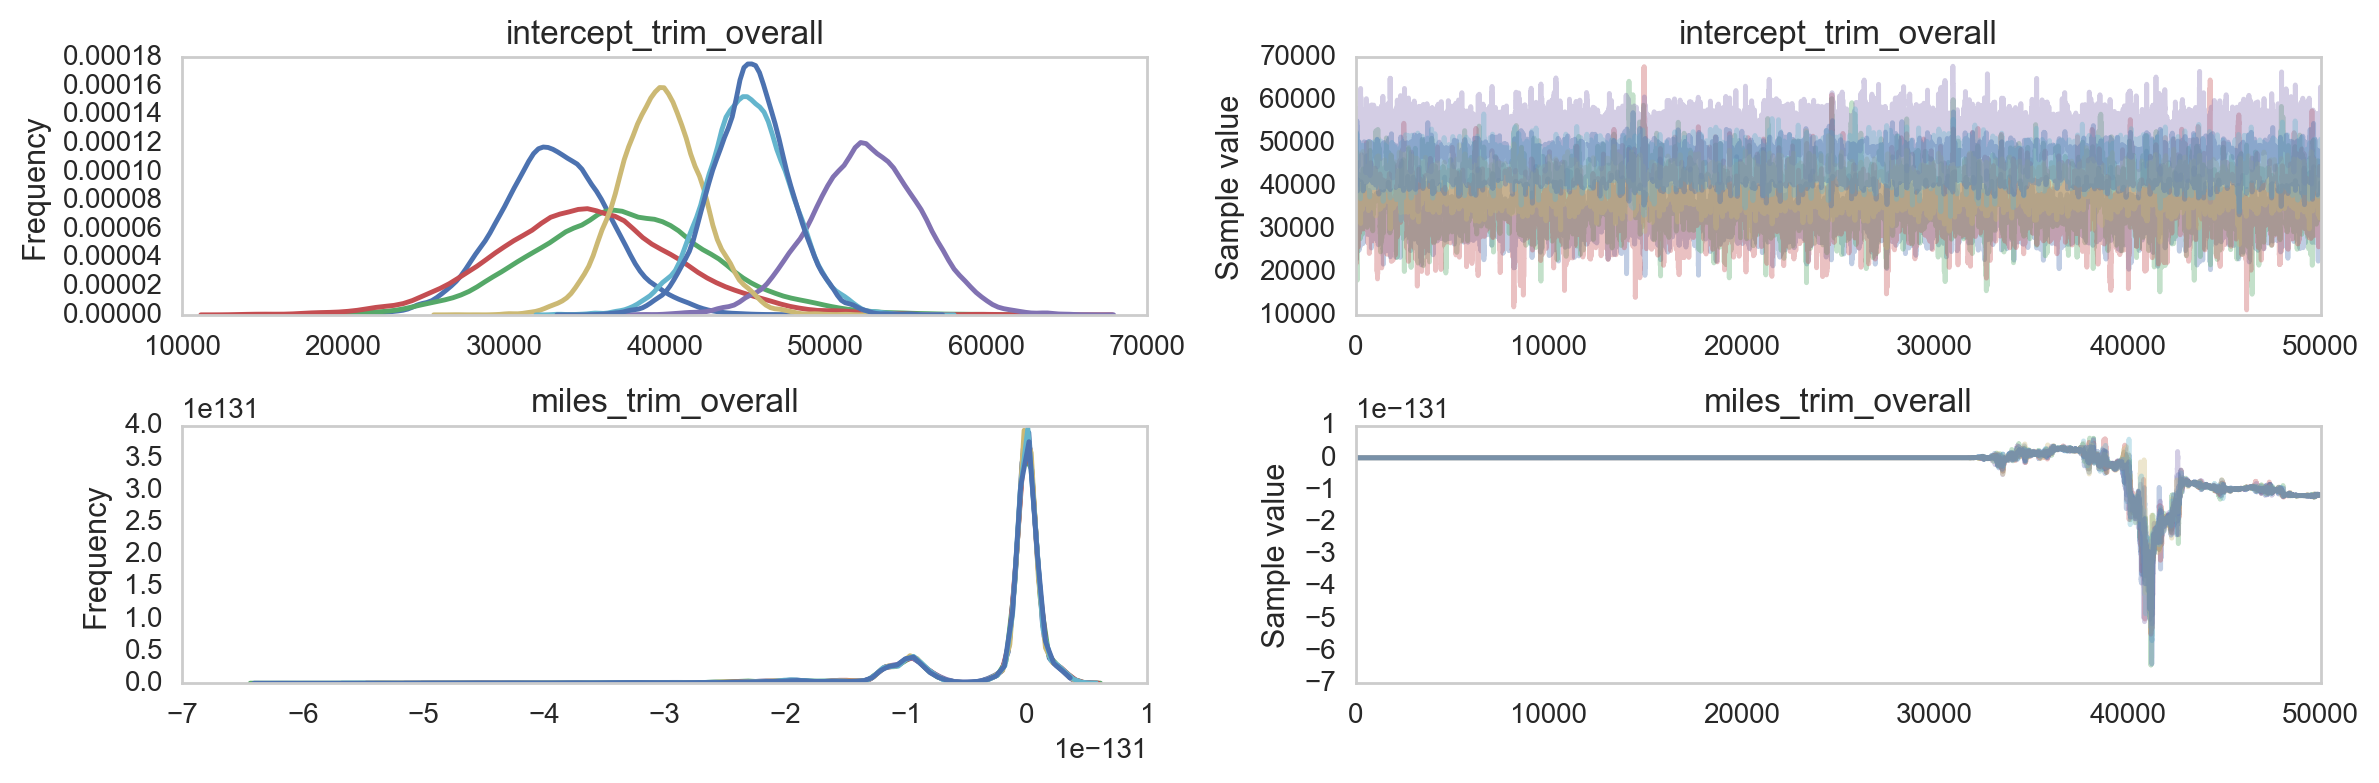

In [145]:
pm.traceplot(bayes_by_ymm['Porsche']['911']['2006'],varnames=['intercept_trim_overall','miles_trim_overall']);

*In this case, I don't think the model is properly defined, as the results from miles_trim_overall are not reasonable.* Despite many effort at tuning the model, I was not able to generate a better fit. 

One way to check the quality of the model fit is to compare the distributions of the predictions and the actual values. 

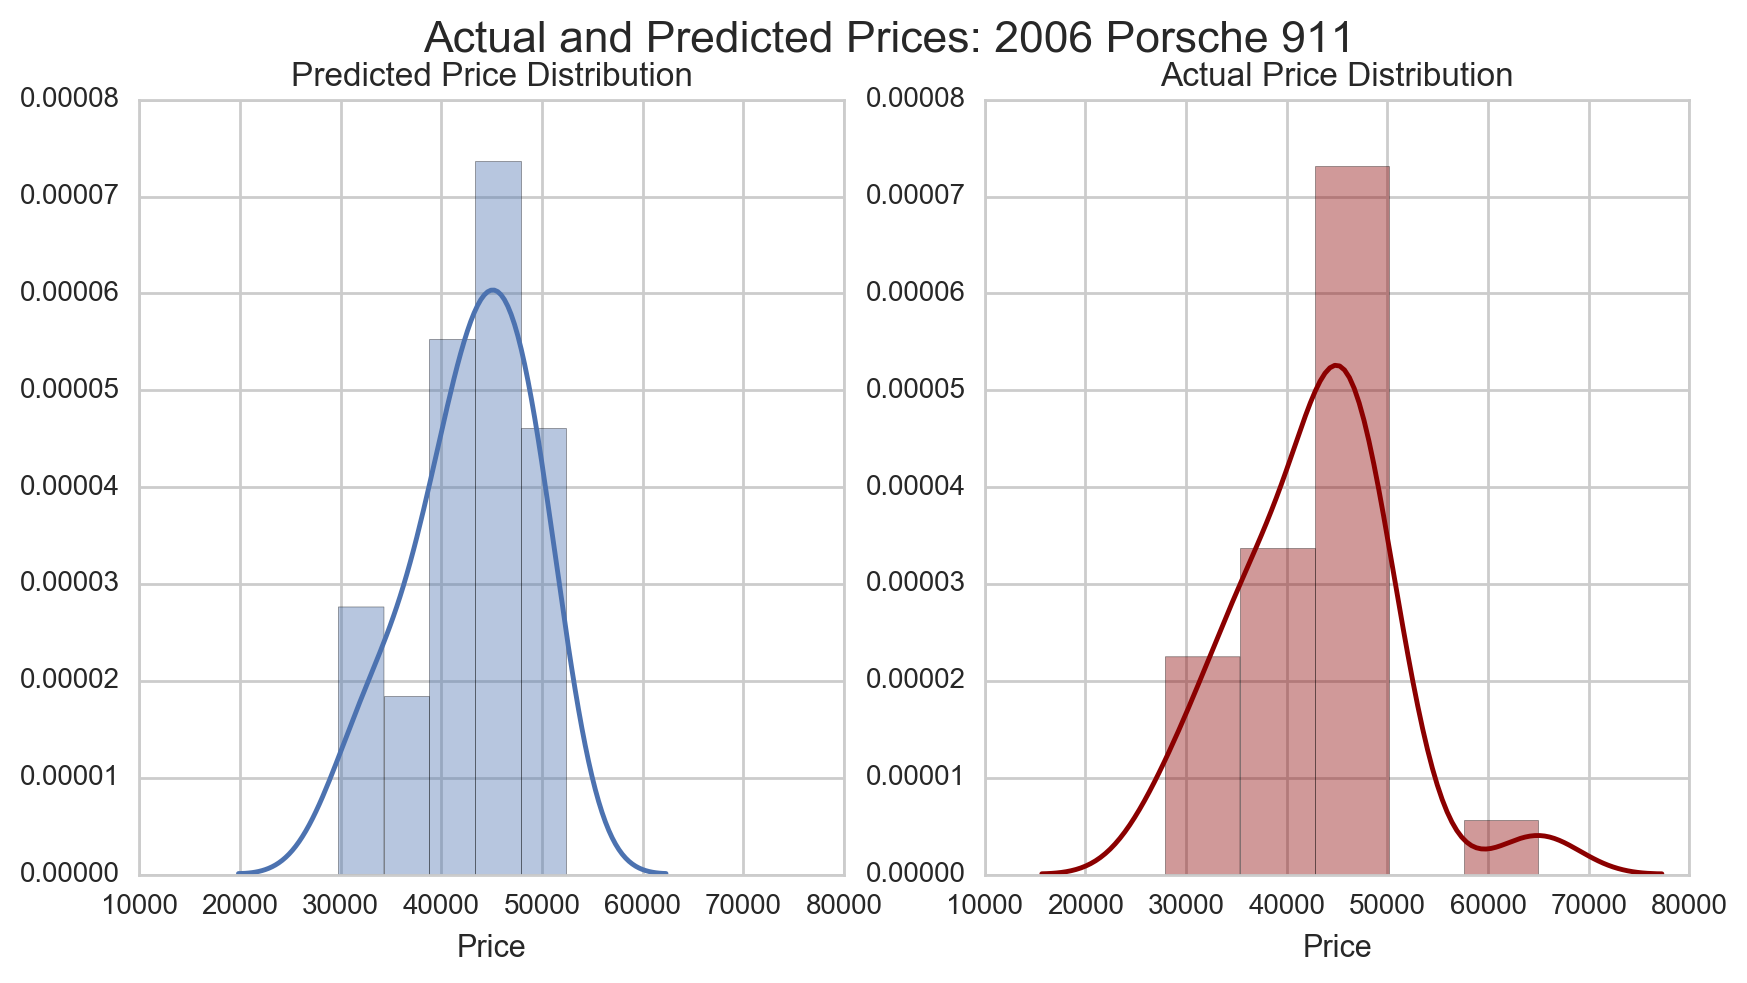

In [35]:
ppc = pm.sample_ppc(bayes_by_ymm['Porsche']['911']['2006'], model=price_ymm,samples=10)
pred_prices = np.mean(ppc['price_like'],axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,5),sharex=True)

fig.suptitle('Actual and Predicted Prices: 2006 Porsche 911',fontsize=16)
# predicted
sns.distplot(pred_prices,ax=ax[0], bins=5)
ax[0].set_title('Predicted Price Distribution')
ax[0].set_xlabel('Price')

# actual
sns.distplot(cc_data_year.price,ax=ax[1], bins=5,color='darkred')
ax[1].set_title('Actual Price Distribution')
ax[1].set_xlabel('Price')

plt.show()

Replot the above information on a single plot.

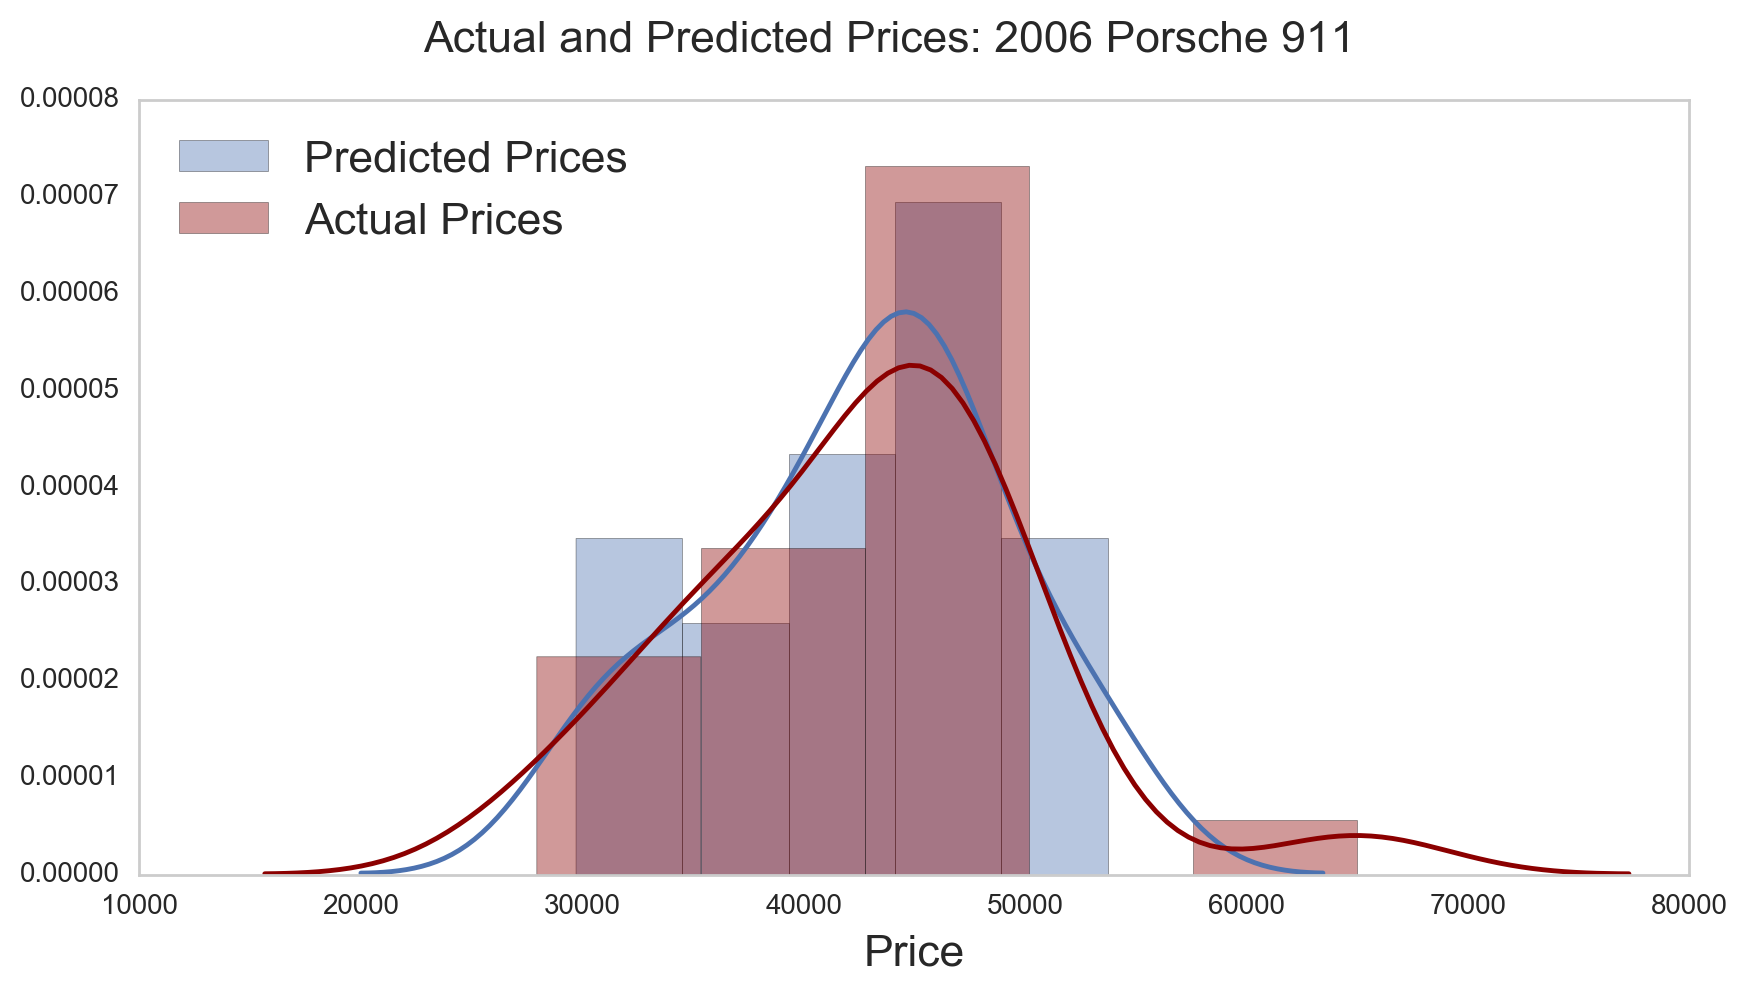

In [141]:
ppc = pm.sample_ppc(bayes_by_ymm['Porsche']['911']['2006'], model=price_ymm,samples=10)
pred_prices = np.mean(ppc['price_like'],axis=0)

fig,ax = plt.subplots(figsize=(10,5),sharex=True)

fig.suptitle('Actual and Predicted Prices: 2006 Porsche 911',fontsize=16)
# predicted
sns.distplot(pred_prices, bins=5,label='Predicted Prices')

# actual
sns.distplot(cc_data_year.price, bins=5,color='darkred',label='Actual Prices')
plt.xlabel('Price',fontsize=16)
plt.legend(loc='upper left',fontsize=16)

plt.show()

We can also look at the predicted price distribution for a single year, make, model, and trim.

The plot_posterior function from pymc3 displays the following information:
- a histogram of the price distribution
- the mean value for the distribution
- a bar and text deliminating the range that contains 95% of the predictions

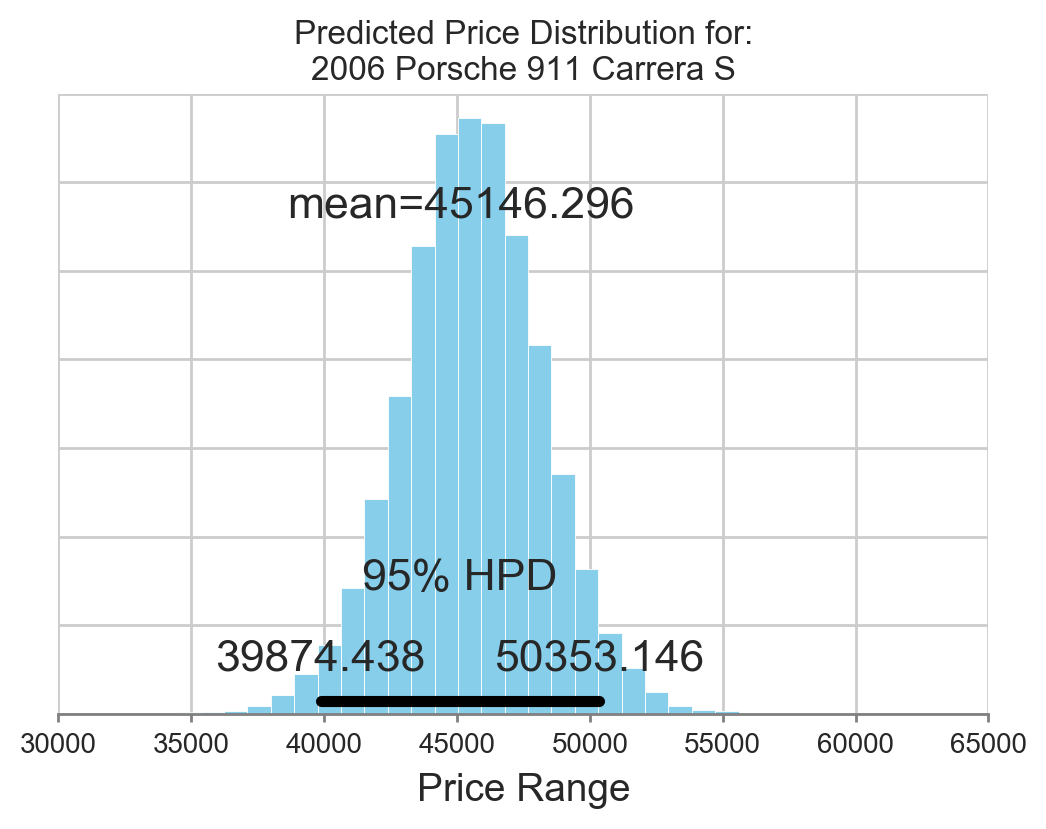

In [36]:
idx = 10
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
pm.plot_posterior(bayes_make_model_year.prob_dists.loc[idx],color='#87ceeb',ax=ax)
plt.title('Predicted Price Distribution for:\n'+bayes_make_model_year.ymmt.loc[idx])
plt.xlabel('Price Range',fontsize=14)
plt.show()

** Load and merge all the dataframes that were generated with the AWS processing.** I will not load in the trace files, as they are used mostly for diagnistic purposes.

In [38]:
# get the list of pickled files from the directory
listdir = os.listdir('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/AWS_bayes/')[1:]

# create a datafram to hold the results
cc_bayes = pd.DataFrame()

# iterate through the files and add each one to the df
count = 0
for listing in listdir:
    # only read in the df files
    if 'df.pgz' in listing:
        path = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/AWS_bayes/' + listing
        temp = load_zipped_pickle(path)
    
        # concatenate the dataframes
        cc_bayes = pd.concat((cc_bayes,temp))
        count += 1

print 'Loaded and concatenated %s dataframes' % count
# put all the rows on the same index
cc_bayes.reset_index(inplace=True,drop=True)
print 'df shape:',cc_bayes.shape
cc_bayes[['ymmt','prob_dists']].head(2)

Loaded and concatenated 52 dataframes
df shape: (8971, 9)


ymmt  \
0          2013 Acura ILX 2.0L   
1  2013 Acura ILX 2.0L Premium   

                                          prob_dists  
0  [16761.2078513, 16761.2078513, 16761.2078513, ...  
1  [18183.1375441, 18183.1375441, 18183.1375441, ...

Merge the calculated probability distributions with cc_data

In [39]:
cc_data = cc_data.merge(cc_bayes[['ymmt','prob_dists']],on='ymmt')

Design a function, price_plotter, that takes a listing index as input and returns two plots:
1. the predicted price distribution plot with a marker indicating where the vehicle of interest is positioned
2. a scatter plot of price vs miles for all vehicles with the same ymmt

In order for this to work with the final output, I will save the figure to a png instead of displaying it in-line.

In [195]:
def price_plotter(ad_index):

    parent = ad_index
    parent_ymmt = cc_data.ymmt.loc[parent]
    
    prob_dist = cc_data.prob_dists.loc[parent]
    # get prices and miles for all ads with identical ymmt
    ymmt_prices = cc_data.price[cc_data.ymmt == parent_ymmt]
    ymmt_miles = cc_data.miles[cc_data.ymmt == parent_ymmt]
    
    # set the upper and lower x limits for the plots
    # they need to be on the same scape

    xmin = np.min(ymmt_prices) - np.min(ymmt_prices)*.10
    xmax = np.max(ymmt_prices) + np.max(ymmt_prices)*.10
    
    # two plots: 1 column, 2 rows
    fig, ax = plt.subplots(2,1,figsize=(5,7))
    
    # top plot is the probability distibution
    # will use the kde plot function for getting our 'dot'
    kde = stats.gaussian_kde(prob_dist, bw_method='scott')

    # get x,y positions for the dot showing the location of the current listing on the distribution
    parent_miles = cc_data.miles.loc[parent]
    parent_price = cc_data.price.loc[parent]
    parent_dist = kde.pdf(cc_data.price.loc[parent])
    
    # probability density plot
    # turn on gridlines
    new_style = {'grid': True}
    matplotlib.rc('axes', **new_style)

    plt.subplot(2,1,1)

    sns.kdeplot(prob_dist,shade=True,zorder=5)
    # add price point for ad
    plt.scatter(x=parent_price, y=parent_dist,s=250, color='darkred',alpha=.9,zorder=10, marker="*")
    plt.ylabel('Price Probability',fontsize=14)
    # turn off the axis tick labels
    plt.tick_params(labelbottom='off',labelleft='off')
    plt.xlim(xmin,xmax)
    
    # bottom plot is miles vs price
    # turn on gridlines
    new_style = {'grid': True}
    matplotlib.rc('axes', **new_style)

    plt.subplot(2,1,2)   

    plt.scatter(x=ymmt_prices, y=ymmt_miles, s=200, marker='*',alpha=0.5)
    plt.scatter(x=parent_price, y = parent_miles, s=250, marker='*', color='darkred')
    
    plt.xlabel('Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Miles',fontsize=14)
    # some of the price distributions may go below zero
    # setting xlim 0 so that isn't displayed
    plt.xlim(xmin,xmax)
    
    plt.tight_layout(pad=0)
    plt.savefig('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/price_plotter.png',
                bbox_inches='tight', pad_inches=0)
    # use this so that the plot isn't automatically displayed
    #plt.ioff()
    plt.close(fig)


ymmt     2013 Ford Fusion SE
price                  14500
Name: 21029, dtype: object


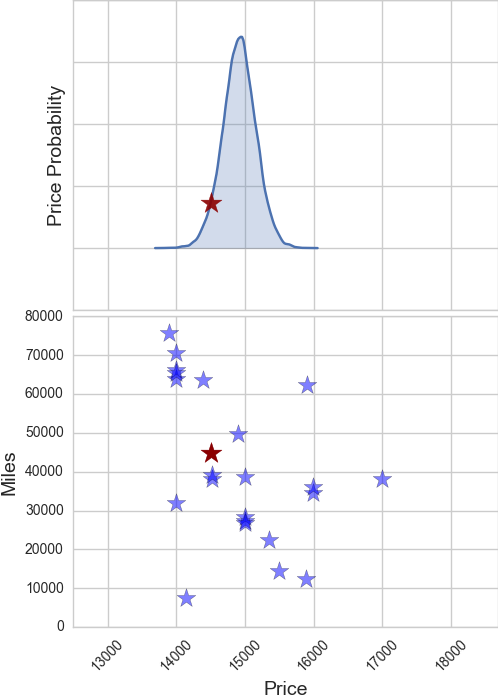

In [196]:
# randomly select a listing
x = np.random.randint(0,cc_data.shape[0])
print cc_data[['ymmt','price']].loc[x]
price_plotter(x)
Image.open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/price_plotter.png')

When there are many vehicles available with the same ymmt, the price distribution becomes quite narrow. This indicates a good 'confidence' in the predicted price.

ymmt     2015 Lexus RX 350 
price                 44000
Name: 30401, dtype: object


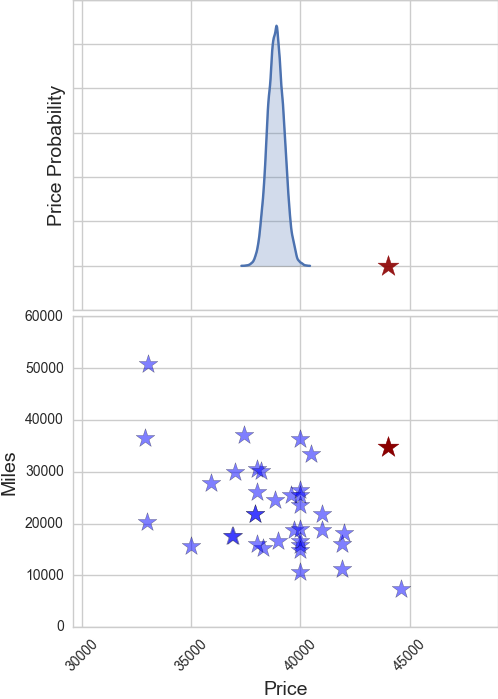

In [197]:
# listing with a price on the high end of the distribution
x = 30401
print cc_data[['ymmt','price']].loc[x]
price_plotter(x)
Image.open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/price_plotter.png')

When there is only one or a few vehicles with a given ymmt, the distribution will be very wide. This reflects that the credible interval is very wide, and the results are heavily influenced by the priors.

ymmt     2014 Toyota Venza XLE
price                    23163
Name: 29156, dtype: object


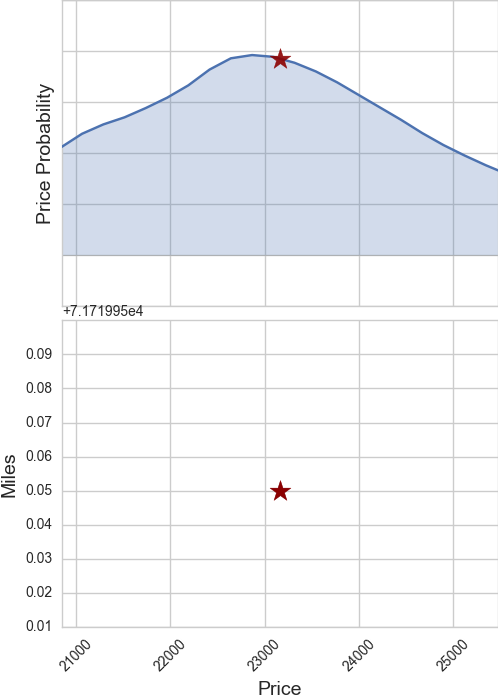

In [198]:
x = 29156
print cc_data[['ymmt','price']].loc[x]
price_plotter(x)
Image.open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/price_plotter.png')

Save the results

In [42]:
save_zipped_pickle(cc_data,'/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/cc_data_probs.pgz')

## 7.2 Recommendation Engine

Need some additional imports here:

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

In order to do content-based filtering, I need to create a 'sentence' that can be used in the tokenization process. I will do that by combing a number of columns together.

In [44]:
def create_sentence(df):
    y = str(df.ymmt)
    t = str(df.transAM)
    b = str(df.bodyStyle)
    d = str(df.doorCount) +'-door'
    dt = str(df.drivetype)
    dt2 = str(df.drivetrain)
    e = str(df.engine)
    extc = str(df.exteriorColor)
    intc = str(df.interiorColor)
    mcity = str(df.mpgCity)+'citympg'
    mhwy = str(df.mpgHwy)+'hwympg'
    p = str(df.price)
    
    s = " ".join([y,t,b,dt,e,extc,intc])
    return s
    
cc_data['sentence'] = cc_data.apply(create_sentence,axis=1)

In [45]:
print cc_data.sentence.loc[5]
print cc_data.sentence.loc[44332]

2006 Maserati GranSport  automatic Convertible RWD 4.2L V8 32V MPFI DOHC Gray Gray
2015 GMC Sierra 1500 Pickup 2D 8 ft automatic Regular Cab Pickup RWD Gas V8 5.3L/325 Summit White Gray


Set up the tokenization using TfidfVectorizer. Use n-gram up to 4, so that it will catch the combinations of 'year make model trim', as that will be important in finding the vehicles with the most similarity.

In [46]:
tf_vectorizer = TfidfVectorizer(ngram_range=(1,4),
                               min_df = 0)

tfidf_matrix = tf_vectorizer.fit_transform(cc_data['sentence'])

Next compute the cosine similarity for each listing against all other listings. This is very computationally intensive and takes significant time to complete.

In [47]:
d1 = datetime.now()
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
d2 = datetime.now()
time_diff = int((d2-d1).total_seconds())
print 'This took %s seconds' % (time_diff)

This took 463 seconds


Using the consine similarity results, create two additional columns:
1. similar_all: the 20 most similar results
2. similar_other_make: the 20 most similar results that are of a different make

In [48]:
d1 = datetime.now()
all_similar = []
other_make_similar = []

for idx, row in cc_data.iterrows():
    if (idx % 5000) == 0:
        print "at index %s" % idx
        
    # limit to the 200 'most similar' listings
    similar_indices = cosine_similarities[idx].argsort()[:-200:-1]
    
    # Need to remove the parent item from the list,
    # otherwise it may show up due to the presence of
    # several indexes with the same value
    similar_indices = similar_indices[similar_indices != idx]

    
    # return the similarity and the index of the similar listing
    similar_items = [(cosine_similarities[idx][i], cc_data.index[i])
                     for i in similar_indices]
    
    # keep the list of all similar results
    # limit to 20 items
    all_similar.append(similar_items[0:20])
    
    # now lok for other makes
    sim_diff_make = []
    for position,(sim,item) in enumerate(similar_items):

        # get 20 similar listings that are a different make
        if cc_data.makeName.loc[idx] != cc_data.makeName.loc[item]:
            if len(sim_diff_make) <= 20:
                sim_diff_make.append(similar_items[position])
             
    # append the other similar makes
    other_make_similar.append(sim_diff_make)

    
cc_data['similar_all'] = all_similar
cc_data['similar_other_make'] = other_make_similar

# save the results
cc_sim_file = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/clean_data/cc_data_probs_and_similarities.pgz'
save_zipped_pickle(cc_data,cc_sim_file)

d2 = datetime.now()
time_diff = int((d2-d1).total_seconds())
print 'This took %s seconds' % (time_diff)

at index 0
at index 5000
at index 10000
at index 15000
at index 20000
at index 25000
at index 30000
at index 35000
at index 40000
This took 1511 seconds


Look at a couple to see if the results seem reasonable...

In [50]:
x = 50

print 'Parent listing: %s\n' % cc_data.sentence.loc[x]
print 'Similarity score and ymmt of top-five most similar listings:'
for i in cc_data.similar_all.loc[x][0:5]:
        print i[0],cc_data.sentence.loc[i[1]]

Parent listing: 2006 Ford F250 Super Duty automatic Crew Cab Pickup AWD 6.0L V8 32V DDI OHV Turbo Diesel Silver Metallic None

Similarity score and ymmt of top-five most similar listings:
0.592466937127 2006 Ford F250 Super Duty automatic Extended Cab Pickup AWD 6.0L V8 32V DDI OHV Turbo Diesel Red Clearcoat Dark Flint
0.572497001769 2014 Ford F250 Super Duty automatic Crew Cab Pickup AWD 6.7L V8 32V DDI OHV Turbo Diesel Oxford White Steel
0.546799017562 2005 Ford F250 Super Duty automatic Crew Cab Pickup AWD 6.0L V8 32V DDI OHV Turbo Diesel Dark Toreador Red Clearcoat Medium Flint
0.510275787312 2007 Ford F350 Lariat Super Duty automatic Crew Cab Pickup AWD 6.0L V8 32V DDI OHV Turbo Diesel White Gray
0.509648090315 2007 Ford F350 Lariat Super Duty automatic Crew Cab Pickup AWD 6.0L V8 32V DDI OHV Turbo Diesel White None


#### Create functions to:

1. Return info about any listing
2. Return a similar model with a lower price
3. Return a similar model with lower miles
4. Return a similar model with a higher price

If there is nothing to return, then will just add some text.

*1*. Return info about any listing

In [51]:
def get_info_to_display(ad_index):
    # this function will take an index from cc_data and return a list with details for printing
    
    # specifics from the listing
    # convert numbers to int
    year = str(cc_data.modelYear.loc[ad_index])
    model = str(cc_data.modelName.loc[ad_index])
    make = str(cc_data.makeName.loc[ad_index])
    trim = str(cc_data.trimName.loc[ad_index])
    price = int(cc_data.price.loc[ad_index])
    miles = int(cc_data.miles.loc[ad_index])
    ad_id = str(cc_data.ad_id.loc[ad_index])
    
    # not every listing has trim
    if trim != 'None':
        model_trim = model + ' ' + trim
    else:
        model_trim = model
        
    # get the file info for photo 0
    photo_file_parent = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/'
    photo_name = "_".join([make,model,year,ad_id,'0.jpg']).lower()
    photo_full = (photo_file_parent + photo_name)
    
    # put everything into a list
    display_info = [photo_full,year,make,model_trim,miles,price,ad_index]
    
    return display_info

*2*. Return similar model with a price 15% lower than the original listing

This will occasionally return none, especially when presented with the lowest priced vehicle of a type. 

In [52]:
def get_lower_price(ad_index):
    parent = ad_index
    parent_price = cc_data.price.loc[parent]
    # return a listing that has a vehicle similar to the original listing,
    # but with at least a 15% lower price
    # for the vehicles at the bottom of the price bracket, it probably not return anything
    
    # this method will take the parent and list of related vehicles for any of the
    # defined searches and return either the lower priced index, or None 
    def get_lower_price_index(parent,related_list):

        for item_score,item_index in related_list:
            # want to find listing with lower price
            d = cc_data.price.loc[parent] - cc_data.price.loc[item_index]        
            # look for price 15% lower than parent
            if (d > (parent_price * 0.15)):
                #if (item_index != get_lower_miles(parent)[6]):
                return item_index

    # look for something that is in the similar overall list
    similar_all_list = cc_data.similar_all.loc[parent]
    if len(similar_all_list) > 0:
        lpi = get_lower_price_index(parent,similar_all_list)
        # check to see if a value was returned or not
        if lpi:
            # If yes, return the details
            return get_info_to_display(lpi)
        
    # tIf no, then look for something that is similar and a different make
    sim_list = cc_data.similar_other_make.loc[parent]
    if len(sim_list) > 0:
        lpi = get_lower_price_index(parent,sim_list)
        # check to see if a value was returned or not
        if lpi:
            return get_info_to_display(lpi)
    
    # if none of the above, return None
    return None


*3*. Return similar model with at least 10% fewer miles than the parent listing. 

The price will likely be higher than the original listing.

In [53]:
def get_lower_miles(ad_index):
    # return a listing that has a vehicle similar to the original listing,
    # but with at least 10% fewer miles
    parent = ad_index
    parent_miles = cc_data.miles.loc[parent]
    
    # this method will take the parent and list of related vehicles for any of the
    # defined searches and return either the index, or None
    def get_lower_miles_index(parent,related_list):

        for item_score,item_index in related_list:
            # want to find listing with lower miles
            d = parent_miles - cc_data.miles.loc[item_index]        
            # look for 10% lower miles than parent
            if (d > (parent_miles * 0.1)):
                return item_index

    # look for something that is in the similar overall list
    similar_all_list = cc_data.similar_all.loc[parent]
    if len(similar_all_list) > 0:
        lpi = get_lower_miles_index(parent,similar_all_list)      
        # check to see if a value was returned or not
        if lpi:
            # If yes
            return get_info_to_display(lpi)
    
    # If no, then look for something that is similar and a different make
    sim_list = cc_data.similar_other_make.loc[parent]
    if len(sim_list) > 0:
        lpi = get_lower_miles_index(parent,sim_list)    
        # check to see if a value was returned or not
        if lpi:
            return get_info_to_display(lpi)
    
    
    # if none of the above, return None
    return None


*4*. Return similar model with a price around that is 1-30% higher than the parent.

In [54]:
def get_stretch_goal(ad_index):
    # this should return a listing that is slightly 'nicer' than
    # the parent listing, or at least more expensive
    parent = ad_index
    parent_price = cc_data.price.loc[parent]
    parent_miles = cc_data.miles.loc[parent]
    
    def get_higher_price(parent,related_list):

        for item_score,item_index in related_list:
            # want to find listing with higher price
            d = cc_data.price.loc[item_index] - cc_data.price.loc[parent]        
            
            # look for price 1-30% higher than parent
            if (d > parent_price * .01) & (d <= (parent_price * .30)):
                if (item_index != get_lower_miles(parent)[6]) & (item_index != get_lower_miles(parent)[6]):
                    return item_index

    # look for something similar 
    similar_all_list = cc_data.similar_all.loc[parent]
    if len(similar_all_list) > 0:
        lpi = get_higher_price(parent,similar_all_list)
        # check to see if a value was returned or not
        if lpi:
            # If yes
            return get_info_to_display(lpi)
        
    # If no, look for anything similar
    similar_other_list = cc_data.similar_other_make.loc[parent]
    if len(similar_other_list) > 0:
        lpi = get_higher_price(parent,similar_other_list)
        # check to see if a value was returned or not
        if lpi:
            return get_info_to_display(lpi)

    return None

In [55]:
x = 50
print '\t\tyear, \tmake, \tmodel, \tmiles, \tprice, \tindex'
print 'original',get_info_to_display(x)
print  'lower price',get_lower_price(x)
print 'lower miles',get_lower_miles(x)
print 'stretch',get_stretch_goal(x)

		year, 	make, 	model, 	miles, 	price, 	index
original ['/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/ford_f250_2006_670195014_0.jpg', '2006', 'Ford', 'F250 Super Duty', 35786, 29500, 50]
lower price ['/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/ford_f250_2006_678589636_0.jpg', '2006', 'Ford', 'F250 Super Duty', 180145, 18995, 51]
lower miles ['/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/ford_f250_2014_635098263_0.jpg', '2014', 'Ford', 'F250 Super Duty', 24356, 39990, 43656]
stretch ['/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/data/carscom/carscom_images/combined/gmc_sierra 2500_2008_676939183_0.jpg', '2008', 'GMC', 'Sierra 2500 SLT', 113690, 33900, 1128]


Create a function that takes a listing index, and returns the lower price, lower miles, and 'stretch goal' listings. If the jpegs are available, show images and some listing information for each one. As above, I will redirect the output to a png for use later.

In [56]:
def show_related(ad_index):
    # this will make sure the gridlines are off
    new_style = {'grid': False}
    matplotlib.rc('axes', **new_style)

    
    # first collect the info about the vehicle and related listings
    original = get_info_to_display(ad_index)
    lowerPrice = get_lower_price(ad_index)
    lowerMiles = get_lower_miles(ad_index)
    otherChoice = get_stretch_goal(ad_index)
    
    # image for cases where nothing is found
    no_car = '/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/no_image_thumb.jpg'
    
    # list of figures and titles
    fig_list = [original, lowerPrice, lowerMiles, otherChoice]
    title_list = ['Original','Lower Price','Lower Miles','Stretch Goal']
    
    # initialize a 2x2 plot
    fig, ax = plt.subplots(2,2,figsize=(8,8))
        
    # populate the subplots
    for i in range(1,5):
        # adjust count to get 0-based for list indexing
        count = i - 1
        # check that there is an object to plot
        if fig_list[count] != None:
            # create the label to go under the photo
            # if the label has more than 30 characters, split into two lines
            ymm = " ".join((fig_list[count][1],fig_list[count][2],fig_list[count][3]))
            if len(ymm) > 30:
                 ymm = " ".join((fig_list[count][1],fig_list[count][2],'\n',fig_list[count][3]))
            # miles and price will be on separate lines
            mp = 'Miles: ' + str(fig_list[count][4]) + '\nPrice: ' + str(fig_list[count][5])
            label = "\n".join((ymm,mp))
            
            # make each plot, testing for image files and setting them all to the same size
            plt.subplot(2,2,i)
            try:
                pil_im = Image.open(fig_list[count][0],'r')
                pil_im = pil_im.resize((640, 480))
            except:
                pil_im = Image.open(no_car,'r')
                pil_im = pil_im.resize((640, 480))
                
            # set tiles and labels
            plt.title(title_list[count],fontsize=18)
            plt.xlabel(label,fontsize=14)
            
            # show the image without tickmarks or other distractions
            imshow(np.asarray(pil_im))
            plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        else:
            # run this if no result was returned from one (or more) of the searches
            plt.subplot(2,2,i)
            pil_im = Image.open(no_car,'r')
            plt.title(title_list[count],fontsize=18)
            plt.xlabel('Nothing found!',fontsize=14)
            imshow(np.asarray(pil_im))
            plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', 
                right='off', left='off', labelleft='off')

    # save the figure
    plt.savefig('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/show_related.png',
                bbox_inches='tight', pad_inches=0)
    # use this so that the plot isn't automatically displayed
    #plt.ioff()
    plt.close(fig)

            

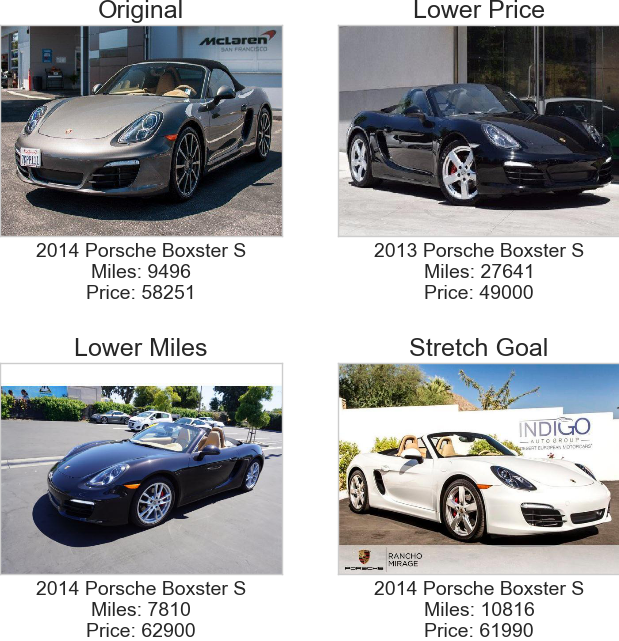

In [119]:
show_related(24653)
Image.open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/show_related.png')

** Now put the two plots together into a single output **

In [58]:
def comp_plotter(ad_index):
    
    parent = ad_index
    # make a an overall figure that will hold each of the other plots
    # will need to optimize sizing and positions
    fig, parent_ax = plt.subplots(figsize=(10,7))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', 
                right='off', left='off', labelleft='off')
    plt.axis('off')
    
    # make the title for the overall image
    info = get_info_to_display(parent)
    ymm = " ".join((info[1],info[2],info[3]))
    price = str(info[5])
    title = ymm+', $'+price
    plt.title(title,fontsize=18)

    # generate the two images for the subplots
    pp = price_plotter(parent)
    sr = show_related(parent)
    
    # price plotter
    pp_ax = inset_axes(parent_ax, width="40%", height="97%", loc=6, borderpad=0)
    pil_im_pp = Image.open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/price_plotter.png','r')
    imshow(np.asarray(pil_im_pp))
    plt.axis('off')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', 
                right='off', left='off', labelleft='off')

    # show related
    sr_ax = inset_axes(parent_ax, width="59%", height="97%", loc=5, borderpad=0)
    pil_im_pp = Image.open('/Users/Chris/Desktop/DSI-SF-2-clrife/capstone/reports/assets/show_related.png','r')
    imshow(np.asarray(pil_im_pp))
    plt.axis('off')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', 
                right='off', left='off', labelleft='off')
    
    plt.show()


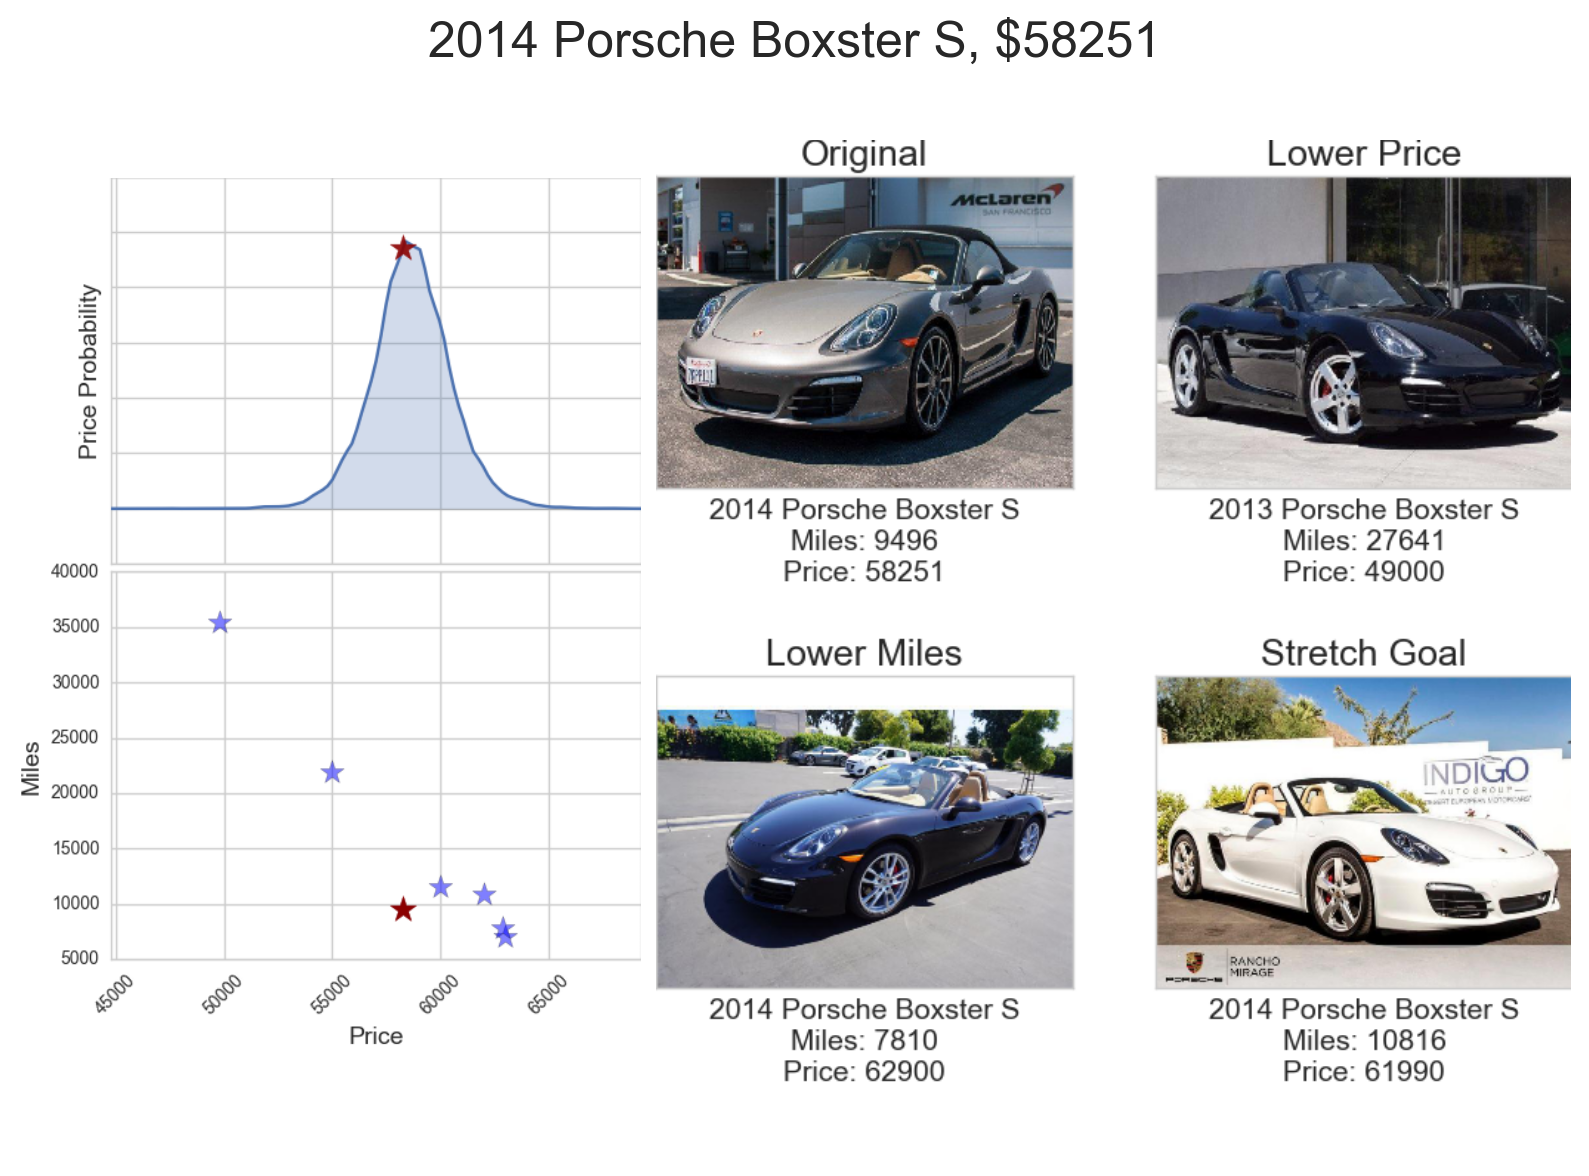

In [199]:
comp_plotter(24653)

# 8. Results and Conclusions

30796


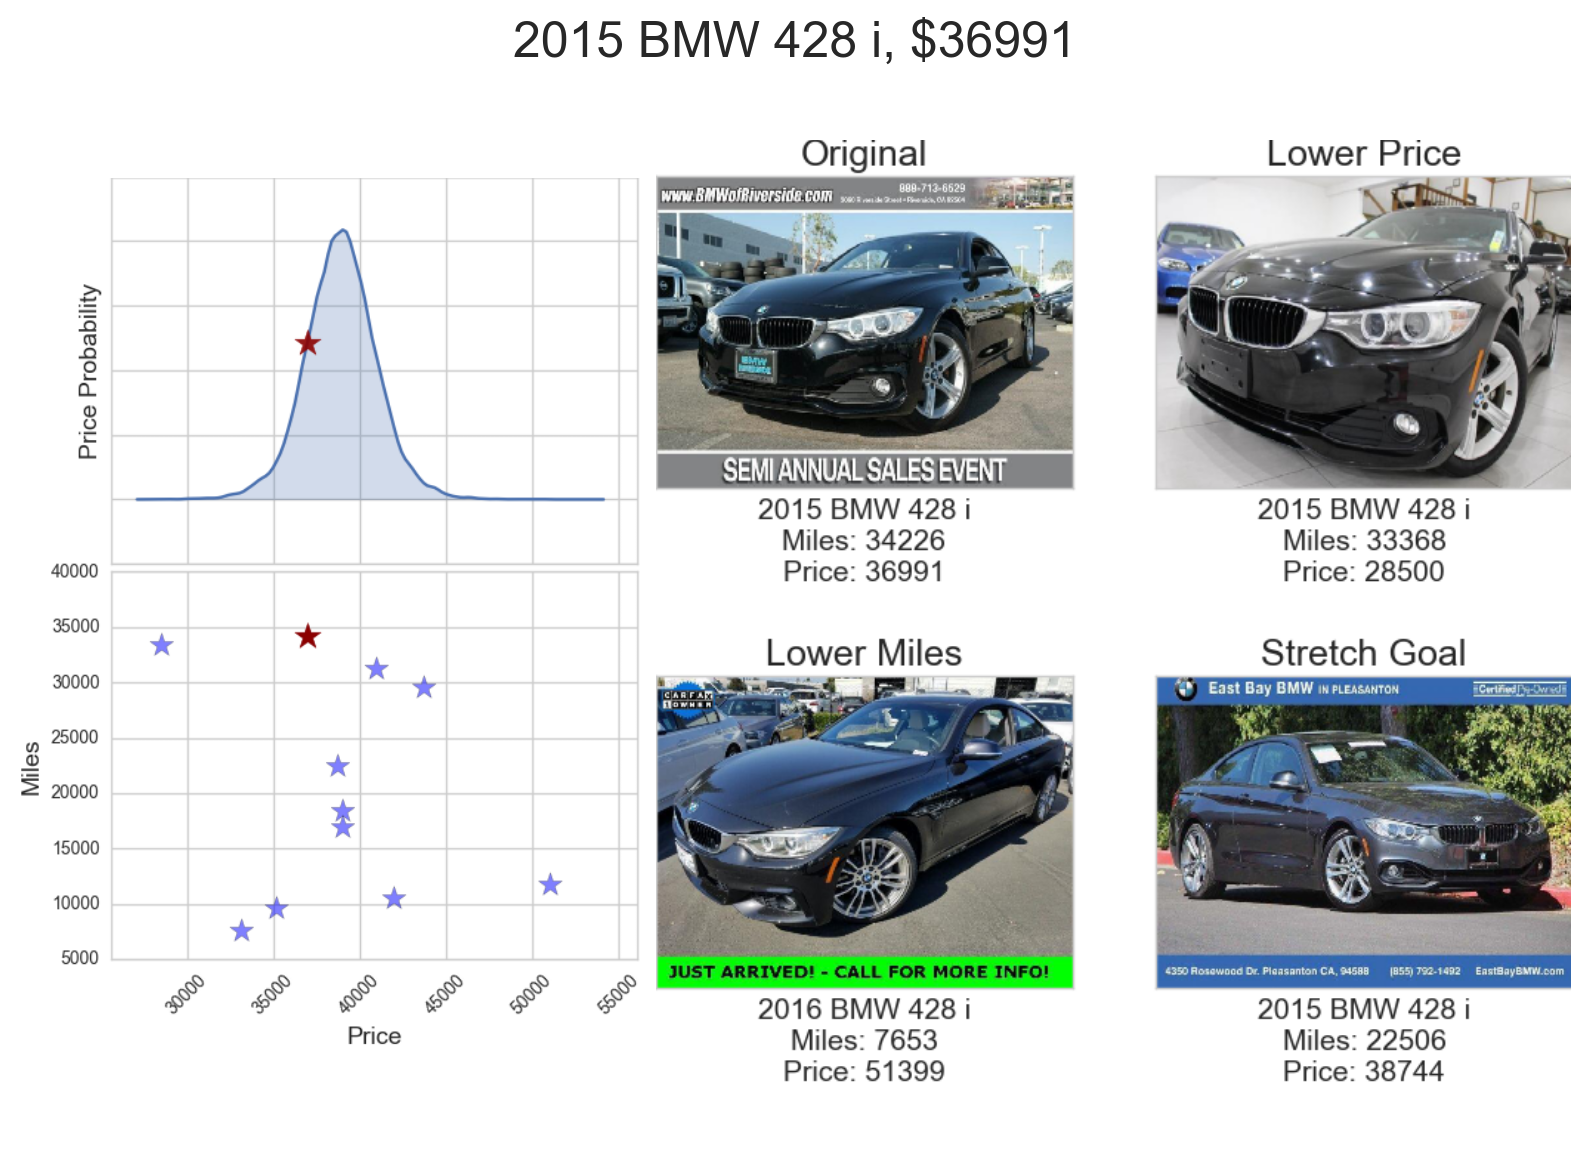

In [209]:
# random listing
x = np.random.randint(0,cc_data.shape[0])
print x
comp_plotter(x)

** Final Plot **

The plot above has several components, and I will go through each of them in general before discussing the models specifically.

1. The title provides the basic info about the vehicle that is being researched.
2. The right-side square of photos compares the parent listing against similar vehicles having a lower price, lower miles, and one that is up to 25% more expensive.
3. The upper-left plot shows the results from the regression. This is the price probability distribution for the specific year, make, and model vehicle, and was calculated with a hierarchical model that accounts for the different trim levels. The star represents where the parent listing falls on the distribution. A narrow distribution implies that there were many data points and that the confidence of the average price for that make-model-year-trim combination is high. This is another way of saying that the credible interval is small. A broad curve indicates that there is more uncertainty in the predicted price. The basic idea here is that if the parent vehicle is not near the predicted average price, then the user should try to understand the discrepancy (i.e., low/high miles).
4. The lower-left plot is a scatterplot showing the price and miles for each vehicle in the dataset with the same make-model-year-trim combination. As in plot 3, the red start highlights the position of the parent listing.


**Regression**

Predicting the prices using Bayesian regression was not as effective as I had anticipated. My initial efforts focused on modeling all prices for each make at once, with year, model, and trim treated as 'prior knowledge' for the calculations. The output parameters of the model looked good, i.e., the traceplots indicated that the model was well fit. However, for the cases where there were single or few data points, the priors pulled the predictions too far towards the mean, with the resulting price distributions often not covering any prices for a given year-make-model-trim combination.

For the final model, I treated each make, model and year independently, and only added the trim level as prior knowledge. This seems to have the desired effect of predicting price distributions that are more in line with the actual prices. The resulting distributions tend to be very wide when there are few prices available, and, conversely, they can be quite narrow if there are a large number of very similar data points. Both of these behaviors are expected based on how the model works, however, they don't communicate the results in exactly the way that I had envisioned.



**Recommendation**

Contrary to the regression model, the content-based recommender was more effective than I expected. Even when the most similar choice is of a different make, it will generally make a good choice as to what is a similar listing. It does suffer when presented with a listing that is either the lowest or highest priced of a year-make-model-trim item. In those cases, it tends to come up with something that is seemingly random. 

**Final Thoughts**

Like most data science problems, this work would have undoubtedly benefitted from cleaner (and more) data. While the details provided in the downloaded listings are quite comprehensive, I was only able to include a small number of the features. And some features, especially *trimName*, were very unreliable. Many of the trim names had multiple variations of the same name, and some had complete nonsense like 'lease this car now!'. I was not able to develop code capable of cleaning up the discrepancies between the various names, and I suspect this had a negative impact on both the regression and recommendation calculations. 

There was an additional data set available at [fueleconomy.gov](http://www.fueleconomy.gov/feg/download.shtml) that contains even more information about specific models. I wasn't able to combine this with my dataset, again in large part due to the issues with trimName. Including that data would provide many more features that would especially enhance the content-based recommendation. 

Future Work:
- Include additional description in the price distribution plot to indicate the *reasonableness* of the price
- Look more in-depth at pricing strategies between different dealers, regions, seasons, etc
- Investigate more thoroughly the factors that go into pricing. While this model only considered miles and trim, there are many other factors that can be used
    - Exterior and interior color
    - Engine, transmission, drive type
    - Cost to own (based on EPA information)
- Collect data over time and predict price trends for each vehicle
    - How fast will it depreciate?
    - What determines the rate of depreciation?
- Build in a way to make the output interactive